<a href="https://colab.research.google.com/github/acrossariver/my_gcola/blob/main/400%E4%B8%87%E3%81%BE%E3%81%A7%E3%81%AE%E9%81%93%E3%81%AE%E3%82%8A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#■スクリーニング

##日経２２５＆プライム３３３

In [ ]:
import yfinance as yf
import pandas as pd
import datetime
import requests
import random
from io import BytesIO

# ==== N225用スクリーニング条件 ====
N225_CONDITIONS = {
    "max_per": 20,
    "max_pbr": 5.0,
    "min_dividend_yield": 3.00,
    "min_up_change_rate": 0.10,
    "min_down_change_rate": -0.10,
    "days": 31,
    "volume_days": 7
}

# ==== P333用スクリーニング条件 ====
P333_CONDITIONS = {
    "max_per": 20,
    "max_pbr": 2.0,
    "min_dividend_yield": 3.00,
    "min_up_change_rate": 0.15,
    "min_down_change_rate": -0.15,
    "days": 31,
    "volume_days": 7
}

PRIME_RANDOM = 333

# ==== スクリーニング関数 ====
def screen_stocks(tickers, category_label, name_map, conditions):
    up_list, down_list = [], []
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            info = stock.info
            per = info.get("trailingPE")
            pbr = info.get("priceToBook")
            div_yield = info.get("dividendYield")

            if None in [per, pbr, div_yield]:
                continue

            if (
                per <= conditions["max_per"]
                and pbr <= conditions["max_pbr"]
                and div_yield >= conditions["min_dividend_yield"]
            ):
                end = datetime.datetime.today()
                start = end - datetime.timedelta(days=conditions["days"])
                hist = stock.history(start=start, end=end)

                if len(hist) < max(2, conditions.get("volume_days", 0)):
                    continue

                start_price = hist["Close"].iloc[0]
                end_price = hist["Close"].iloc[-1]
                change_rate = (end_price - start_price) / start_price

                result = {
                    "カテゴリー": category_label,
                    "銘柄コード": ticker,
                    "PER": per,
                    "PBR": pbr,
                    "配当利回り": f"{div_yield:.2f}%",
                    "株価変化率": f"{change_rate * 100:.2f}%",
                    "上昇/下降": "上昇" if change_rate >= conditions["min_up_change_rate"] else "下降"
                }

                # ==== 出来高傾向（可変日数）を追加 ====
                vol_days = conditions.get("volume_days", 0)
                if vol_days > 1 and len(hist["Volume"]) >= vol_days:
                    volume = hist["Volume"].tail(vol_days)
                    mid = vol_days // 2
                    vol_early = volume.iloc[:mid].mean()
                    vol_late = volume.iloc[mid:].mean()
                    volume_trend = "増加" if vol_late > vol_early else "減少"
                    result["出来高"] = volume_trend

                if change_rate >= conditions["min_up_change_rate"]:
                    up_list.append(result)
                elif change_rate <= conditions["min_down_change_rate"]:
                    down_list.append(result)
        except Exception as e:
            print(f"エラー: {ticker} - {e}")

    df_up = pd.DataFrame(up_list)
    df_down = pd.DataFrame(down_list)

    if not df_up.empty:
        df_up = df_up.merge(name_map, on="銘柄コード", how="left")
        cols = ['カテゴリー', '銘柄コード', '銘柄名'] + [c for c in df_up.columns if c not in ['カテゴリー', '銘柄コード', '銘柄名']]
        df_up = df_up[cols]

    if not df_down.empty:
        df_down = df_down.merge(name_map, on="銘柄コード", how="left")
        cols = ['カテゴリー', '銘柄コード', '銘柄名'] + [c for c in df_down.columns if c not in ['カテゴリー', '銘柄コード', '銘柄名']]
        df_down = df_down[cols]

    return df_up, df_down

# ==== 日経225のティッカー取得 ====
def get_nikkei225():
    url = "https://raw.githubusercontent.com/nakachan-ing/finance-streamlit/master/nikkei.csv"
    df = pd.read_csv(url, encoding='shift_jis')
    df['銘柄コード'] = df['コード'].astype(str) + '.T'
    return df['銘柄コード'].tolist(), df[['銘柄コード', '銘柄名']]




# ==== 東証プライム銘柄をExcelから取得 ====
def get_prime333():
    xls_url = 'https://www.jpx.co.jp/markets/statistics-equities/misc/tvdivq0000001vg2-att/data_j.xls'
    response = requests.get(xls_url)
    df = pd.read_excel(BytesIO(response.content), sheet_name=0)
    df.columns = df.columns.str.strip()
    df = df[df['市場・商品区分'].str.contains('プライム', na=False)].copy()
    df['銘柄コード'] = df['コード'].astype(str).str.zfill(4) + '.T'
    tickers = random.sample(df['銘柄コード'].tolist(), PRIME_RANDOM)
    return tickers, df[['銘柄コード', '銘柄名']]

# ==== 実行 ====
tickers_n225, name_map_n225 = get_nikkei225()
tickers_prime, name_map_prime = get_prime333()

print(f"▶ N225銘柄数: {len(tickers_n225)} / P333銘柄数: {len(tickers_prime)}")

df_up_n225, df_down_n225 = screen_stocks(tickers_n225, "N225", name_map_n225, N225_CONDITIONS)
df_up_p333, df_down_p333 = screen_stocks(tickers_prime, "P333", name_map_prime, P333_CONDITIONS)

df_all_n225 = pd.concat([df_up_n225, df_down_n225], ignore_index=True)
df_all_p333 = pd.concat([df_up_p333, df_down_p333], ignore_index=True)
df_all_total = pd.concat([df_all_n225, df_all_p333], ignore_index=True)

print(f"\n◎ 総合 結果件数: {len(df_all_total)}")

# ==== スクリーニング日と日経平均株価の列を追加 ====
today_str = datetime.datetime.today().strftime("%Y/%m/%d")
df_all_total.insert(0, "スクリーニング日", today_str)

nikkei = yf.Ticker("^N225")
nikkei_today_price = nikkei.history(period="1d")["Open"].iloc[-1]
df_all_total.insert(1, "日経平均株価", round(nikkei_today_price, 2))

# ==== 表示・保存 ====
from IPython.display import display
display(df_all_total)

from google.colab import files
df_all_total.to_csv("N225_P333.csv", index=False, encoding='utf-8-sig')
files.download("N225_P333.csv")

▶ N225銘柄数: 225 / P333銘柄数: 333

◎ 総合 結果件数: 5


,スクリーニング日,日経平均株価,カテゴリー,銘柄コード,銘柄名,PER,PBR,配当利回り,株価変化率,上昇/下降,出来高
0,2025/06/29,39866.36,N225,6703.T,ＯＫＩ,11.074035,0.948254,6.28%,15.77%,上昇,増加
1,2025/06/29,39866.36,N225,6770.T,アルプスアル,8.503235,0.776914,3.84%,11.59%,上昇,増加
2,2025/06/29,39866.36,N225,7733.T,オリンパス,15.797665,2.436456,3.69%,-12.50%,下降,増加
3,2025/06/29,39866.36,P333,6508.T,明電舎,13.368984,1.781586,3.23%,25.29%,上昇,増加
4,2025/06/29,39866.36,P333,8585.T,オリエントコーポレーション,11.876689,0.691735,8.27%,15.12%,上昇,増加


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#■簡易バックテスト

##通常バックテスト

yahoo financeを取得する際に取得日（つまり今日）を堺に過去に遡る


In [ ]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import numpy as np

# ====== バックテストパラメータ（必要に応じて変更） ======
BACKTEST_YEARS = 10          # バックテストする年数（このバージョンでは直接使われませんが互換性のため残します）
HOLDING_DAYS = 10            # 購入後、上昇達成を判定する営業日数（例: 10営業日以内）
# 目標上昇率のリストを設定（2.0%と2.5%のみに限定）
RISE_THRESHOLDS = [0.02, 0.025]

# ====== ユーティリティ関数: 銘柄名と株価データを取得する ======
def get_stock_data_and_name(ticker, backtest_years):
    """
    指定された銘柄の株価データと銘柄名を取得する。
    データ取得に失敗した場合はNoneを返す。
    """
    company_name = "不明な銘柄"
    df = pd.DataFrame()

    try:
        ticker_info = yf.Ticker(ticker)
        # yfinanceのticker.infoが401エラーになることがあるため、getで安全にアクセス
        info_data = ticker_info.get('info', {})
        company_name = info_data.get('longName', info_data.get('shortName', "不明な銘柄"))
    except Exception as e:
        # print(f"DEBUG: 銘柄名取得エラー: {e}")
        pass

    end_date = datetime.today()
    start_date = end_date - timedelta(days=365 * backtest_years)

    try:
        df = yf.download(ticker,
                         start=start_date.strftime("%Y-%m-%d"),
                         end=end_date.strftime("%Y-%m-%d"),
                         auto_adjust=True,
                         progress=False,
                         threads=False,
                         timeout=10
                        )
    except Exception as e:
        print(f"エラー: 株価データ取得中に問題が発生しました。詳細: {e}")
        return None, company_name

    if df.empty:
        print(f"エラー: データ取得に失敗しました。銘柄コード {ticker} を確認してください。Yahoo Finance側の問題の可能性もあります。")
        return None, company_name

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    required_columns = ['Close', 'High']
    if not all(col in df.columns for col in required_columns):
        print(f"エラー: 取得したデータに {', '.join(required_columns)} 列が見つかりません。")
        return None, company_name

    df = df[required_columns].copy()

    for col in required_columns:
        df[col] = df[col].astype(float, errors='ignore')

    df.dropna(subset=required_columns, inplace=True)

    if df.empty:
        print(f"エラー: '{', '.join(required_columns)}' 列に有効なデータがありませんでした。バックテストを実行できません。")
        return None, company_name

    df = df.reset_index(drop=True)

    return df, company_name

# ====== バックテスト関数 ======
def calculate_rise_rates_for_threshold(df, company_name, ticker, holding_days, threshold):
    """
    指定されたデータフレームとパラメータでバックテストを実行する。
    データフレームは事前に取得・整形済みであることを想定。
    """
    df_temp = df.copy()

    df_temp['Previous_Close'] = df_temp['Close'].shift(1)
    # Ensure division handles zero or NaN previous close
    df_temp['Daily_Close_Return'] = (df_temp['Close'] - df_temp['Previous_Close']) / df_temp['Previous_Close'].replace(0, np.nan)
    df_temp['Daily_High_Return'] = (df_temp['High'] - df_temp['Previous_Close']) / df_temp['Previous_Close'].replace(0, np.nan)
    df_temp.dropna(subset=['Daily_Close_Return', 'Daily_High_Return'], inplace=True)

    daily_close_rise_count = (df_temp['Daily_Close_Return'] >= threshold).sum()
    daily_high_rise_count = (df_temp['Daily_High_Return'] >= threshold).sum()
    total_daily_data_points = len(df_temp)

    daily_close_rise_rate = daily_close_rise_count / total_daily_data_points if total_daily_data_points > 0 else 0.0
    daily_high_rise_rate = daily_high_rise_count / total_daily_data_points if total_daily_data_points > 0 else 0.0

    high_success = 0
    close_success = 0
    total_trades = 0

    if len(df) <= holding_days:
        return {"company_name": company_name,
                "high_achieved_rate": np.nan, "close_achieved_rate": np.nan,
                "daily_close_rise_rate": round(daily_close_rise_rate, 4),
                "daily_high_rise_rate": round(daily_high_rise_rate, 4),
                "total_trades": 0}

    for i in range(len(df) - holding_days):
        buy_price = df.iloc[i]["Close"]

        if pd.isna(buy_price) or buy_price <= 0:
             continue

        future_data = df.iloc[i + 1 : i + 1 + holding_days]

        if future_data.empty:
            continue

        total_trades += 1

        max_high = future_data["High"].max()
        if pd.notna(max_high) and max_high >= buy_price * (1 + threshold):
            high_success += 1

        target_reached_by_close_series = future_data["Close"] >= buy_price * (1 + threshold)
        if target_reached_by_close_series.any():
            close_success += 1

    high_rate = high_success / total_trades if total_trades > 0 else 0.0
    close_rate = close_success / total_trades if total_trades > 0 else 0.0

    return {
        "company_name": company_name,
        "high_achieved_rate": round(high_rate, 4),
        "close_achieved_rate": round(close_rate, 4),
        "daily_close_rise_rate": round(daily_close_rise_rate, 4),
        "daily_high_rise_rate": round(daily_high_rise_rate, 4),
        "total_trades": total_trades
    }

# ====== 実行 ======
if __name__ == "__main__":
    ticker_input = input("銘柄コードを入力してください（例: 7203, 9984, GOOGL）: ").strip()

    # 日本株コードに '.T' が付いていない場合、付与する
    if ticker_input.isdigit():
        ticker_symbol = ticker_input + '.T'
    else:
        ticker_symbol = ticker_input

    # データ取得
    stock_df, company_name = get_stock_data_and_name(ticker_symbol, BACKTEST_YEARS)

    if stock_df is None:
        print(f"\n{'#'*50}")
        print(f"  致命的なエラーによりバックテストを中断しました。")
        print(f"  銘柄コード: {ticker_symbol} のデータ取得に失敗しました。")
        print(f"  入力された銘柄コードが正しいか、またはYahoo Financeのサービス状態をご確認ください。")
        print(f"{'#'*50}\n")
    else:
        # ヘッダー情報を出力
        print(f"\n{'='*50}")
        print(f"  **{company_name} ({ticker_symbol})**")
        print(f"  検証期間: 過去{BACKTEST_YEARS}年 | 判定期間: {HOLDING_DAYS}営業日以内")
        print(f"{'='*50}\n")

        # 各閾値のバックテスト結果を収集
        all_results = {}
        for threshold in RISE_THRESHOLDS:
            all_results[threshold] = calculate_rise_rates_for_threshold(
                stock_df.copy(), company_name, ticker_symbol, HOLDING_DAYS, threshold
            )

        # 固定のハイフン数と列幅を定義
        ITEM_COL_HYPHENS = 25  # 項目後のハイフン数
        HEADER_VALUE_HYPHENS = 3 # ヘッダー値の左右のハイフン数 ('---2.0%---' の部分)

        # 項目名の文字列と、その後のハイフン数に合わせた全体の長さ
        ITEM_COL_WIDTH_FOR_HEADER_LINE = len("項目") + ITEM_COL_HYPHENS

        # ヘッダー行の構築
        header_line = "項目" + "-" * ITEM_COL_HYPHENS

        for i, threshold in enumerate(RISE_THRESHOLDS):
            col_header_str = f'{threshold*100:.1f}%'
            right_hyphens = HEADER_VALUE_HYPHENS - (1 if threshold == 0.025 else 0)
            header_line += f"|{'-' * HEADER_VALUE_HYPHENS}{col_header_str}{'-' * right_hyphens}"

        print(header_line)

        # 区切り線 (二行目) の構築
        separator_item_part = "-" * (ITEM_COL_HYPHENS + len("項目"))

        separator_value_parts = [
            "-" * (len(f'{RISE_THRESHOLDS[0]*100:.1f}%') + HEADER_VALUE_HYPHENS * 2),
            "-" * (len(f'{RISE_THRESHOLDS[1]*100:.1f}%') + HEADER_VALUE_HYPHENS + (HEADER_VALUE_HYPHENS - 1))
        ]

        print(f"{separator_item_part}+{'+'.join(separator_value_parts)}")


        # 各項目ごとのデータ行の構築
        item_labels_raw = [
            f'高値達成率 ({HOLDING_DAYS}日以内}})', # Escape curly brace
            f'終値達成率 ({HOLDING_DAYS}日以内}})', # Escape curly brace
            '単日終値達成率',
            '単日高値達成率',
            f'仮想売買回数 ({HOLDING_DAYS}日以内}})' # Escape curly brace
        ]
        item_data_hyphen_map = {
            f'高値達成率 ({HOLDING_DAYS}日以内}})': 7, # Escape curly brace
            f'終値達成率 ({HOLDING_DAYS}日以内}})': 7, # Escape curly brace
            '単日終値達成率': 15,
            '単日高値達成率': 15,
            f'仮想売買回数 ({HOLDING_DAYS}日以内}})': 5 # Escape curly brace
        }

        value_prefix_hyphen_map = {
            'percentage_long': '--',
            'percentage_short': '---',
            'trades_long': '---',
        }
        value_suffix_hyphen_map = {
            'percentage_common': '--',
            'trades_short': '--', # 2.5% の仮想売買回数
            'trades_long': '---', # 2.0% の仮想売買回数
        }


        for i, raw_label in enumerate(item_labels_raw):
            current_item_hyphens = item_data_hyphen_map[raw_label]
            item_line_prefix = f"{raw_label}" + "-" * current_item_hyphens
            current_line = item_line_prefix

            for j, threshold in enumerate(RISE_THRESHOLDS):
                res = all_results[threshold]

                val_str = ""
                val_str_padded = ""

                if raw_label == f'高値達成率 ({HOLDING_DAYS}日以内}})':
                    val_str = f"{res['high_achieved_rate']*100:.2f}%" if pd.notna(res['high_achieved_rate']) else "N/A"
                    val_str_padded = f"{value_prefix_hyphen_map['percentage_long']}{val_str}{value_suffix_hyphen_map['percentage_common']}"
                elif raw_label == f'終値達成率 ({HOLDING_DAYS}日以内}})':
                    val_str = f"{res['close_achieved_rate']*100:.2f}%" if pd.notna(res['close_achieved_rate']) else "N/A"
                    val_str_padded = f"{value_prefix_hyphen_map['percentage_long']}{val_str}{value_suffix_hyphen_map['percentage_common']}"
                elif raw_label == '単日終値達成率':
                    val_str = f"{res['daily_close_rise_rate']*100:.2f}%"
                    val_str_padded = f"{value_prefix_hyphen_map['percentage_short']}{val_str}{value_suffix_hyphen_map['percentage_common']}"
                elif raw_label == '単日高値達成率':
                    val_str = f"{res['daily_high_rise_rate']*100:.2f}%"
                    val_str_padded = f"{value_prefix_hyphen_map['percentage_long']}{val_str}{value_suffix_hyphen_map['percentage_common']}"
                elif raw_label == f'仮想売買回数 ({HOLDING_DAYS}日以内}})':
                    val_str = str(res['total_trades'])
                    if threshold == 0.02: # 2.0% の列
                        val_str_padded = f"{value_prefix_hyphen_map['trades_long']}{val_str}{value_suffix_hyphen_map['trades_long']}"
                    else: # 2.5% の列
                        val_str_padded = f"{value_prefix_hyphen_map['trades_long']}{val_str}{value_suffix_hyphen_map['trades_short']}"

                cell_width = len(f'{RISE_THRESHOLDS[0]*100:.1f}%') + HEADER_VALUE_HYPHENS * 2 if j == 0 else \
                             len(f'{RISE_THRESHOLDS[1]*100:.1f}%') + HEADER_VALUE_HYPHENS + (HEADER_VALUE_HYPHENS - 1)

                current_line += f"|{val_str_padded:<{cell_width}}"

            print(current_line)

        print(f"\n{'='*50}\n")

銘柄コードを入力してください（例: 7203, 9984, GOOGL）: 6770

  **不明な銘柄 (6770.T)**
  検証期間: 過去10年 | 判定期間: 10営業日以内

項目-------------------------|---2.0%---|---2.5%--
---------------------------+----------+---------
高値達成率 (10日以内})-------|--72.36%--|--66.16%--
終値達成率 (10日以内})-------|--59.93%--|--54.50%--
単日終値達成率---------------|---13.73%--|---9.91%--
単日高値達成率---------------|--28.55%--|--20.76%--
仮想売買回数 (10日以内})-----|---2453---|---2453--




##決算発表日用バックテスト （購入日指定用）


このコードはまず十分なバックテストデータを今日を起点に取得し、その後、inputで指定した決算発表日（OR 指定月日）前後のみのデータをピックアップしてバックテストをする。


ただ、購入日から何日以内の2.0%か2.5%の達成率という指定もあり、少し複雑になっている。


購入した日の１０日以内の達成率を条件にし、指定日前後１０日をバックテスト日にするというのが良い気がする

In [ ]:
#指定日前後を分けていないバージョン

import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import numpy as np
import warnings
import os # ファイル存在チェック用


warnings.filterwarnings('ignore', category=FutureWarning)

# ====== バックテストパラメータ（必要に応じて変更） ======
BACKTEST_YEARS = 10          # バックテストする年数（Yahoo Financeからのデータ取得時のみ影響）
HOLDING_DAYS = 10            # 購入後、上昇達成を判定を判定する営業日数（例: 10営業日以内）
# 目標上昇率のリストを設定（2.0%と2.5%のみに限定）
RISE_THRESHOLDS = [0.02, 0.025]
# ★変更★ FISCAL_DATES はユーザー入力に変更するため、ここでは削除。

# FISCAL_PERIOD_DAYS_AROUND はユーザー入力に変更するため、ここでは削除。

# ====== ユーティリティ関数: 銘柄名と株価データを取得する (Yahoo Finance) ======
def get_stock_data_and_name_yf(ticker, backtest_years):
    """
    指定された銘柄の株価データと銘柄名を取得する (Yahoo Finance経由)。
    データ取得に失敗した場合はNoneを返す。
    """
    company_name = "不明な銘柄"
    df = pd.DataFrame()

    try:
        ticker_info = yf.Ticker(ticker)
        # yfinanceのticker.infoが401エラーになることがあるため、getで安全にアクセス
        info_data = ticker_info.get('info', {})
        company_name = info_data.get('longName', info_data.get('shortName', "不明な銘柄"))
        if not company_name: # company_nameが空の場合の最終的なフォールバック
            company_name = "不明な銘柄"
    except Exception as e:
        # print(f"DEBUG: 銘柄名取得エラー: {e}")
        pass

    end_date = datetime.today() + timedelta(days=1) # 当日データも取得できるように翌日を指定
    start_date = end_date - timedelta(days=365 * backtest_years + 60) # 決算日周辺もカバーできるように長めに取得

    try:
        df = yf.download(ticker,
                         start=start_date.strftime("%Y-%m-%d"),
                         end=end_date.strftime("%Y-%m-%d"),
                         auto_adjust=True,
                         progress=False,
                         threads=False,
                         timeout=10)
    except Exception as e:
        print(f"エラー: Yahoo Financeからの株価データ取得中に問題が発生しました。詳細: {e}")
        return None, company_name

    if df.empty:
        print(f"エラー: Yahoo Financeからのデータ取得に失敗しました。銘柄コード {ticker} を確認してください。Yahoo Finance側の問題の可能性もあります。")
        return None, company_name

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    required_columns = ['Close', 'High']
    if not all(col in df.columns for col in required_columns):
        print(f"エラー: 取得したデータに {', '.join(required_columns)} 列が見つかりません。")
        return None, company_name

    df = df[required_columns].copy()

    for col in required_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce') # 強制的に数値型に変換し、変換できない場合はNaN

    df.dropna(subset=required_columns, inplace=True)

    if df.empty:
        print(f"エラー: '{', '.join(required_columns)}' 列に有効なデータがありませんでした。バックテストを実行できません。")
        return None, company_name

    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    return df, company_name

# ★追加★ 手動データ入力（CSV読み込み）関数
def load_data_from_csv(file_path):
    """
    CSVファイルから株価データを読み込む。
    想定フォーマット: Date,Close,High (または大文字小文字問わず類似)
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"エラー: ファイルが見つかりません: {file_path}")
        return None
    except Exception as e:
        print(f"エラー: CSVファイルの読み込み中に問題が発生しました。詳細: {e}")
        return None

    # 列名の正規化（大文字小文字、スペース、アンダースコアを考慮）
    df.columns = [col.strip().replace(' ', '_').lower() for col in df.columns]

    # 必要な列が存在するか確認
    if 'date' not in df.columns:
        print("エラー: CSVファイルに 'Date' 列が見つかりません。")
        return None
    if 'close' not in df.columns:
        print("エラー: CSVファイルに 'Close' 列が見つかりません。")
        return None
    if 'high' not in df.columns:
        print("エラー: CSVファイルに 'High' 列が見つかりません。")
        return None

    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    df = df[['close', 'high']].copy()
    df.columns = ['Close', 'High'] # Yahoo Financeのデータ形式に合わせる

    for col in ['Close', 'High']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df.dropna(subset=['Close', 'High'], inplace=True)

    if df.empty:
        print("エラー: CSVファイルに有効な株価データがありませんでした。")
        return None

    df = df.sort_index()
    return df

# ---
## 決算発表日の前後期間データを抽出する関数
#---
def extract_fiscal_period_data(df: pd.DataFrame, fiscal_dates: list[str],
                                 days_around: int) -> pd.DataFrame:
    """
    データフレームから指定された決算発表日の前後期間のデータを抽出する。

    Args:
        df (pd.DataFrame): 日付インデックスを持つ株価データフレーム。
        fiscal_dates (list[str]): 抽出したい決算発表日 ('MMDD' 形式の文字列リスト)。
        days_around (int): 決算発表日の前後何日間を対象とするか。

    Returns:
        pd.DataFrame: 抽出されたデータフレーム。空の可能性あり。
    """
    filtered_data_list = []
    # データの存在する年のみを対象とする
    unique_years = df.index.year.unique()

    for year in unique_years:
        for fiscal_date_str in fiscal_dates:
            try:
                # 決算発表日をdatetimeオブジェクトに変換
                month = int(fiscal_date_str[:2])
                day = int(fiscal_date_str[2:])
                fiscal_datetime = datetime(year, month, day)
            except ValueError:
                print(f"警告: 不正な決算発表日形式が検出されました: {fiscal_date_str}。スキップします。")
                continue

            # 決算発表日の前後期間を計算
            period_start = fiscal_datetime - timedelta(days=days_around)
            period_end = fiscal_datetime + timedelta(days=days_around)

            # 期間内のデータを抽出
            # df.loc[] を使って日付範囲で抽出
            period_df = df.loc[(df.index >= period_start) & (df.index <= period_end)].copy()
            if not period_df.empty:
                filtered_data_list.append(period_df)

    if not filtered_data_list:
        return pd.DataFrame()

    # 抽出した全てのデータを結合し、重複を削除して日付でソート
    combined_df = pd.concat(filtered_data_list).drop_duplicates().sort_index()

    # バックテスト関数が reset_index を前提としているため、ここで実行
    # ここで日付インデックスをリセットすることで、calculate_rise_rates_for_threshold 内のilocが正しく動作します
    return combined_df.reset_index(drop=True)


# ====== バックテスト関数 ======
def calculate_rise_rates_for_threshold(df, company_name, ticker, holding_days, threshold):
    """
    指定されたデータフレームとパラメータでバックテストを実行する。
    データフレームは事前に取得・整形済みであることを想定。
    """
    df_temp = df.copy()

    if df_temp.empty:
        return {"company_name": company_name,
                "high_achieved_rate": np.nan, "close_achieved_rate": np.nan,
                "daily_close_rise_rate": np.nan,
                "daily_high_rise_rate": np.nan,
                "total_trades": 0}

    # shift(1) の前にデータが十分に存在するか確認
    if len(df_temp) < 2:
        return {"company_name": company_name,
                "high_achieved_rate": np.nan, "close_achieved_rate": np.nan,
                "daily_close_rise_rate": np.nan,
                "daily_high_rise_rate": np.nan,
                "total_trades": 0}


    df_temp['Previous_Close'] = df_temp['Close'].shift(1)
    df_temp['Daily_Close_Return'] = (df_temp['Close'] - df_temp['Previous_Close']) / df_temp['Previous_Close']
    df_temp['Daily_High_Return'] = (df_temp['High'] - df_temp['Previous_Close']) / df_temp['Previous_Close']
    df_temp.dropna(subset=['Daily_Close_Return', 'Daily_High_Return'], inplace=True)

    # dropna後にデータが空になった場合のチェックを追加
    if df_temp.empty:
        return {"company_name": company_name,
                "high_achieved_rate": np.nan, "close_achieved_rate": np.nan,
                "daily_close_rise_rate": np.nan,
                "daily_high_rise_rate": np.nan,
                "total_trades": 0}


    daily_close_rise_count = (df_temp['Daily_Close_Return'] >= threshold).sum()
    daily_high_rise_count = (df_temp['Daily_High_Return'] >= threshold).sum()
    total_daily_data_points = len(df_temp)

    daily_close_rise_rate = daily_close_rise_count / total_daily_data_points if total_daily_data_points > 0 else 0.0
    daily_high_rise_rate = daily_high_rise_count / total_daily_data_points if total_daily_data_points > 0 else 0.0

    high_success = 0
    close_success = 0
    total_trades = 0

    if len(df_temp) <= holding_days: # df_temp を使用
        return {"company_name": company_name,
                "high_achieved_rate": np.nan, "close_achieved_rate": np.nan,
                "daily_close_rise_rate": round(daily_close_rise_rate, 4),
                "daily_high_rise_rate": round(daily_high_rise_rate, 4),
                "total_trades": 0}

    for i in range(len(df_temp) - holding_days): # df_temp を使用
        buy_price = df_temp.iloc[i]["Close"]

        if pd.isna(buy_price) or buy_price <= 0:
             continue

        future_data = df_temp.iloc[i + 1 : i + 1 + holding_days] # df_temp を使用

        if future_data.empty:
            continue

        total_trades += 1

        max_high = future_data["High"].max()
        if pd.notna(max_high) and max_high >= buy_price * (1 + threshold):
            high_success += 1

        target_reached_by_close_series = future_data["Close"] >= buy_price * (1 + threshold)
        if target_reached_by_close_series.any():
            close_success += 1

    high_rate = high_success / total_trades if total_trades > 0 else 0.0
    close_rate = close_success / total_trades if total_trades > 0 else 0.0

    return {
        "company_name": company_name,
        "high_achieved_rate": round(high_rate, 4),
        "close_achieved_rate": round(close_rate, 4),
        "daily_close_rise_rate": round(daily_close_rise_rate, 4),
        "daily_high_rise_rate": round(daily_high_rise_rate, 4),
        "total_trades": total_trades
    }

# ====== 実行 ======
if __name__ == "__main__":
    ticker_symbol = None
    company_name = "不明な銘柄"
    full_stock_df = None

    # --- データの取得方法を選択 ---
    input_method = input("株価データの入力方法を選択してください (1: Yahoo Finance, 2: CSVファイル): ").strip()

    if input_method == '1':
        ticker_input = input("銘柄コードを入力してください（例: 7203, 9984, GOOGL）: ").strip()
        if ticker_input.isdigit():
            ticker_symbol = ticker_input + '.T'
        else:
            ticker_symbol = ticker_input

        full_stock_df, company_name = get_stock_data_and_name_yf(ticker_symbol, BACKTEST_YEARS)

    elif input_method == '2':
        csv_file_path = input("CSVファイルのパスを入力してください（例: data.csv）: ").strip()
        if not os.path.exists(csv_file_path):
            print(f"エラー: 指定されたCSVファイルが見つかりません: {csv_file_path}")
            print(f"\n{'#'*50}")
            print(f"  致命的なエラーによりバックテストを中断しました。")
            print(f"  CSVファイルが見つかりませんでした。")
            print(f"{'#'*50}\n")
            exit() # プログラムを終了

        full_stock_df = load_data_from_csv(csv_file_path)
        if full_stock_df is not None:
            company_name = input("銘柄名を入力してください（手動入力用）: ").strip()
            ticker_symbol = "手動入力" # 手動入力の場合のticker_symbol
        else:
            # CSV読み込み失敗時のエラーメッセージはload_data_from_csv内で表示される
            print(f"\n{'#'*50}")
            print(f"  致命的なエラーによりバックテストを中断しました。")
            print(f"  CSVデータ読み込みに失敗しました。")
            print(f"{'#'*50}\n")
            exit() # プログラムを終了

    else:
        print(f"\n{'#'*50}")
        print(f"  無効な入力方法です。1 または 2 を入力してください。")
        print(f"  バックテストを中断します。")
        print(f"{'#'*50}\n")
        exit()

    if full_stock_df is None or full_stock_df.empty:
        print(f"\n{'#'*50}")
        print(f"  致命的なエラーによりバックテストを中断しました。")
        print(f"  データ取得または読み込みに失敗しました。入力された情報をご確認ください。")
        print(f"{'#'*50}\n")
    else:
        # --- 決算発表日と期間の手動入力 ---
        while True:
            fiscal_dates_input = input("決算発表日をカンマ区切りで入力してください (例: 0315,0930): ").strip()
            FISCAL_DATES_LIST = [d.strip() for d in fiscal_dates_input.split(',') if d.strip()]

            # 入力された日付のフォーマットチェック
            invalid_dates = [d for d in FISCAL_DATES_LIST if not (len(d) == 4 and d.isdigit() and 1 <= int(d[:2]) <= 12 and 1 <= int(d[2:]) <= 31)]
            if invalid_dates:
                print(f"エラー: 無効な決算発表日形式があります: {', '.join(invalid_dates)}。MMDD形式で入力してください。")
                continue # 再入力

            if not FISCAL_DATES_LIST:
                print("エラー: 決算発表日が入力されていません。")
                continue # 再入力

            break # 正しい入力があればループを抜ける

        while True:
            try:
                FISCAL_PERIOD_DAYS_AROUND = int(input("決算発表日の前後何日間を対象としますか？ (例: 7): ").strip())
                if FISCAL_PERIOD_DAYS_AROUND < 0:
                    print("エラー: 日数は0以上の整数で入力してください。")
                    continue
                break
            except ValueError:
                print("エラー: 有効な整数を入力してください。")

        # 決算発表日の前後期間のデータを抽出
        fiscal_period_df = extract_fiscal_period_data(
            full_stock_df, FISCAL_DATES_LIST, FISCAL_PERIOD_DAYS_AROUND
        )

        if fiscal_period_df.empty:
            print(f"\n{'#'*50}")
            print(f"  データ抽出エラー:")
            print(f"  指定された決算発表日 ({', '.join(FISCAL_DATES_LIST)}) の前後{FISCAL_PERIOD_DAYS_AROUND}日間のデータが見つかりませんでした。")
            print(f"  バックテストは実行されません。")
            print(f"{'#'*50}\n")
        else:
            # ヘッダー情報を出力
            print(f"\n{'='*50}")
            print(f"  **{company_name} ({ticker_symbol})**")
            print(f"  検証期間: 過去の決算発表日 ({', '.join(FISCAL_DATES_LIST)}) の前後{FISCAL_PERIOD_DAYS_AROUND}日のみ")
            print(f"  判定期間: {HOLDING_DAYS}営業日以内")
            print(f"{'='*50}\n")

            # 各閾値のバックテスト結果を収集
            all_results = {}
            for threshold in RISE_THRESHOLDS:
                all_results[threshold] = calculate_rise_rates_for_threshold(
                    fiscal_period_df.copy(), company_name, ticker_symbol, HOLDING_DAYS, threshold
                )

            # 固定のハイフン数と列幅を定義 (表示部分のロジックは変更なし)
            ITEM_COL_HYPHENS = 25
            HEADER_VALUE_HYPHENS = 3

            header_line = "項目" + "-" * ITEM_COL_HYPHENS

            for i, threshold in enumerate(RISE_THRESHOLDS):
                col_header_str = f'{threshold*100:.1f}%'
                right_hyphens = HEADER_VALUE_HYPHENS - (1 if threshold == 0.025 else 0)
                header_line += f"|{'-' * HEADER_VALUE_HYPHENS}{col_header_str}{'-' * right_hyphens}"
            print(header_line)

            separator_item_part = "-" * (ITEM_COL_HYPHENS + len("項目"))
            separator_value_parts = [
                "-" * (len(f'{RISE_THRESHOLDS[0]*100:.1f}%') + HEADER_VALUE_HYPHENS * 2),
                "-" * (len(f'{RISE_THRESHOLDS[1]*100:.1f}%') + HEADER_VALUE_HYPHENS + (HEADER_VALUE_HYPHENS - 1))
            ]
            print(f"{separator_item_part}+{'+'.join(separator_value_parts)}")

            item_labels_raw = [
                f'高値達成率 ({HOLDING_DAYS}日以内)',
                f'終値達成率 ({HOLDING_DAYS}日以内)',
                '単日終値達成率',
                '単日高値達成率',
                f'仮想売買回数 ({HOLDING_DAYS}日以内)'
            ]
            item_data_hyphen_map = {
                f'高値達成率 ({HOLDING_DAYS}日以内)': 7,
                f'終値達成率 ({HOLDING_DAYS}日以内)': 7,
                '単日終値達成率': 15,
                '単日高値達成率': 15,
                f'仮想売買回数 ({HOLDING_DAYS}日以内)': 5
            }

            value_prefix_hyphen_map = {
                'percentage_long': '--',
                'percentage_short': '---',
                'trades_long': '---',
            }
            value_suffix_hyphen_map = {
                'percentage_common': '--',
                'trades_short': '--',
                'trades_long': '---',
            }

            for i, raw_label in enumerate(item_labels_raw):
                current_item_hyphens = item_data_hyphen_map[raw_label]
                item_line_prefix = f"{raw_label}" + "-" * current_item_hyphens
                current_line = item_line_prefix

                for j, threshold in enumerate(RISE_THRESHOLDS):
                    res = all_results[threshold]
                    val_str = ""
                    val_str_padded = ""

                    if raw_label == f'高値達成率 ({HOLDING_DAYS}日以内)':
                        val_str = f"{res['high_achieved_rate']*100:.2f}%" if pd.notna(res['high_achieved_rate']) else "N/A"
                        if val_str == "N/A":
                            val_str_padded = f"{value_prefix_hyphen_map['percentage_long']}{val_str:<7}{value_suffix_hyphen_map['percentage_common']}"
                        else:
                            val_str_padded = f"{value_prefix_hyphen_map['percentage_long']}{val_str}{value_suffix_hyphen_map['percentage_common']}"
                    elif raw_label == f'終値達成率 ({HOLDING_DAYS}日以内)':
                        val_str = f"{res['close_achieved_rate']*100:.2f}%" if pd.notna(res['close_achieved_rate']) else "N/A"
                        if val_str == "N/A":
                            val_str_padded = f"{value_prefix_hyphen_map['percentage_long']}{val_str:<7}{value_suffix_hyphen_map['percentage_common']}"
                        else:
                            val_str_padded = f"{value_prefix_hyphen_map['percentage_long']}{val_str}{value_suffix_hyphen_map['percentage_common']}"
                    elif raw_label == '単日終値達成率':
                        val_str = f"{res['daily_close_rise_rate']*100:.2f}%" if pd.notna(res['daily_close_rise_rate']) else "N/A"
                        if val_str == "N/A":
                            val_str_padded = f"{value_prefix_hyphen_map['percentage_short']}{val_str:<7}{value_suffix_hyphen_map['percentage_common']}"
                        else:
                            val_str_padded = f"{value_prefix_hyphen_map['percentage_short']}{val_str}{value_suffix_hyphen_map['percentage_common']}"
                    elif raw_label == '単日高値達成率':
                        val_str = f"{res['daily_high_rise_rate']*100:.2f}%" if pd.notna(res['daily_high_rise_rate']) else "N/A"
                        if val_str == "N/A":
                            val_str_padded = f"{value_prefix_hyphen_map['percentage_long']}{val_str:<7}{value_suffix_hyphen_map['percentage_common']}"
                        else:
                            val_str_padded = f"{value_prefix_hyphen_map['percentage_long']}{val_str}{value_suffix_hyphen_map['percentage_common']}"
                    elif raw_label == f'仮想売買回数 ({HOLDING_DAYS}日以内)':
                        val_str = str(res['total_trades'])
                        if pd.isna(res['total_trades']):
                            val_str = "N/A"
                            if threshold == 0.02:
                                val_str_padded = f"{value_prefix_hyphen_map['trades_long']}{val_str:<7}{value_suffix_hyphen_map['trades_long']}"
                            else:
                                val_str_padded = f"{value_prefix_hyphen_map['trades_long']}{val_str:<7}{value_suffix_hyphen_map['trades_short']}"
                        else:
                            if threshold == 0.02:
                                val_str_padded = f"{value_prefix_hyphen_map['trades_long']}{val_str}{value_suffix_hyphen_map['trades_long']}"
                            else:
                                val_str_padded = f"{value_prefix_hyphen_map['trades_long']}{val_str}{value_suffix_hyphen_map['trades_short']}"

                    cell_width = len(f'{RISE_THRESHOLDS[0]*100:.1f}%') + HEADER_VALUE_HYPHENS * 2 if j == 0 else \
                                 len(f'{RISE_THRESHOLDS[1]*100:.1f}%') + HEADER_VALUE_HYPHENS + (HEADER_VALUE_HYPHENS - 1)

                    current_line += f"|{val_str_padded:<{cell_width}}"

                print(current_line)

            print(f"\n{'='*50}\n")

株価データの入力方法を選択してください (1: Yahoo Finance, 2: CSVファイル): 1
銘柄コードを入力してください（例: 7203, 9984, GOOGL）: 4022
決算発表日をカンマ区切りで入力してください (例: 0315,0930): 0630
決算発表日の前後何日間を対象としますか？ (例: 7): 10

  **不明な銘柄 (4022.T)**
  検証期間: 過去の決算発表日 (0630) の前後10日のみ
  判定期間: 10営業日以内

項目-------------------------|---2.0%---|---2.5%--
---------------------------+----------+---------
高値達成率 (10日以内)-------|--83.82%--|--78.68%--
終値達成率 (10日以内)-------|--75.00%--|--74.26%--
単日終値達成率---------------|---18.49%--|---14.38%--
単日高値達成率---------------|--31.51%--|--23.29%--
仮想売買回数 (10日以内)-----|---136--- |---136-- 




In [ ]:
#指定日前後を分けて表示するもの


import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import numpy as np
import warnings
import os # ファイル存在チェック用


warnings.filterwarnings('ignore', category=FutureWarning)

# ====== バックテストパラメータ（必要に応じて変更） ======
BACKTEST_YEARS = 10          # バックテストする年数（Yahoo Financeからのデータ取得時のみ影響）
HOLDING_DAYS = 10           # 購入後、上昇達成を判定を判定する営業日数（例: 10営業日以内）
# 目標上昇率のリストを設定（2.0%と2.5%のみに限定）
RISE_THRESHOLDS = [0.02, 0.025]
# ★変更★ FISCAL_DATES はユーザー入力に変更するため、ここでは削除。

# FISCAL_PERIOD_DAYS_AROUND はユーザー入力に変更するため、ここでは削除。

# ====== ユーティリティ関数: 銘柄名と株価データを取得する (Yahoo Finance) ======
def get_stock_data_and_name_yf(ticker, backtest_years):
    """
    指定された銘柄の株価データと銘柄名を取得する (Yahoo Finance経由)。
    データ取得に失敗した場合はNoneを返す。
    """
    company_name = "不明な銘柄"
    df = pd.DataFrame()

    try:
        ticker_info = yf.Ticker(ticker)
        # yfinanceのticker.infoが401エラーになることがあるため、getで安全にアクセス
        info_data = ticker_info.get('info', {})
        company_name = info_data.get('longName', info_data.get('shortName', "不明な銘柄"))
        if not company_name: # company_nameが空の場合の最終的なフォールバック
            company_name = "不明な銘柄"
    except Exception as e:
        # print(f"DEBUG: 銘柄名取得エラー: {e}")
        pass

    end_date = datetime.today() + timedelta(days=1) # 当日データも取得できるように翌日を指定
    start_date = end_date - timedelta(days=365 * backtest_years + 60) # 決算日周辺もカバーできるように長めに取得

    try:
        df = yf.download(ticker,
                         start=start_date.strftime("%Y-%m-%d"),
                         end=end_date.strftime("%Y-%m-%d"),
                         auto_adjust=True,
                         progress=False,
                         threads=False,
                         timeout=10
                        )
    except Exception as e:
        print(f"エラー: Yahoo Financeからの株価データ取得中に問題が発生しました。詳細: {e}")
        return None, company_name

    if df.empty:
        print(f"エラー: Yahoo Financeからのデータ取得に失敗しました。銘柄コード {ticker} を確認してください。Yahoo Finance側の問題の可能性もあります。")
        return None, company_name

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    required_columns = ['Close', 'High']
    if not all(col in df.columns for col in required_columns):
        print(f"エラー: 取得したデータに {', '.join(required_columns)} 列が見つかりません。")
        return None, company_name

    df = df[required_columns].copy()

    for col in required_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce') # 強制的に数値型に変換し、変換できない場合はNaN

    df.dropna(subset=required_columns, inplace=True)

    if df.empty:
        print(f"エラー: '{', '.join(required_columns)}' 列に有効なデータがありませんでした。バックテストを実行できません。")
        return None, company_name

    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    return df, company_name

# ★追加★ 手動データ入力（CSV読み込み）関数
def load_data_from_csv(file_path):
    """
    CSVファイルから株価データを読み込む。
    想定フォーマット: Date,Close,High (または大文字小文字問わず類似)
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"エラー: ファイルが見つかりません: {file_path}")
        return None
    except Exception as e:
        print(f"エラー: CSVファイルの読み込み中に問題が発生しました。詳細: {e}")
        return None

    # 列名の正規化（大文字小文字、スペース、アンダースコアを考慮）
    df.columns = [col.strip().replace(' ', '_').lower() for col in df.columns]

    # 必要な列が存在するか確認
    if 'date' not in df.columns:
        print("エラー: CSVファイルに 'Date' 列が見つかりません。")
        return None
    if 'close' not in df.columns:
        print("エラー: CSVファイルに 'Close' 列が見つかりません。")
        return None
    if 'high' not in df.columns:
        print("エラー: CSVファイルに 'High' 列が見つかりません。")
        return None

    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    df = df[['close', 'high']].copy()
    df.columns = ['Close', 'High'] # Yahoo Financeのデータ形式に合わせる

    for col in ['Close', 'High']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df.dropna(subset=['Close', 'High'], inplace=True)

    if df.empty:
        print("エラー: CSVファイルに有効な株価データがありませんでした。")
        return None

    df = df.sort_index()
    return df

# ---
## 決算発表日の前後期間データを抽出する関数 (修正版)
#---
def extract_fiscal_period_data(df: pd.DataFrame, fiscal_dates: list[str],
                                 days_around: int) -> dict[str, pd.DataFrame]:
    """
    データフレームから指定された決算発表日の前後期間のデータを抽出し、
    前後全体、前のみ、後のみの3種類のデータフレームを返す。

    Args:
        df (pd.DataFrame): 日付インデックスを持つ株価データフレーム。
        fiscal_dates (list[str]): 抽出したい決算発表日 ('MMDD' 形式の文字列リスト)。
        days_around (int): 決算発表日の前後何日間を対象とするか。

    Returns:
        dict[str, pd.DataFrame]:
            'all_around': 決算発表日の前後期間全体のデータフレーム。
            'before': 決算発表日の前期間のデータフレーム。
            'after': 決算発表日の後期間のデータフレーム。
            各キーに対応するデータフレームは空の可能性あり。
    """
    all_around_data_list = []
    before_data_list = []
    after_data_list = []

    # データの存在する年のみを対象とする
    unique_years = df.index.year.unique()

    for year in unique_years:
        for fiscal_date_str in fiscal_dates:
            try:
                # 決算発表日をdatetimeオブジェクトに変換
                month = int(fiscal_date_str[:2])
                day = int(fiscal_date_str[2:])
                fiscal_datetime = datetime(year, month, day)
            except ValueError:
                print(f"警告: 不正な決算発表日形式が検出されました: {fiscal_date_str}。スキップします。")
                continue

            # 決算発表日の前後期間を計算
            period_start_all = fiscal_datetime - timedelta(days=days_around)
            period_end_all = fiscal_datetime + timedelta(days=days_around)

            # 前期間: 決算発表日のdays_around日前から決算発表日の前日まで
            period_start_before = fiscal_datetime - timedelta(days=days_around)
            period_end_before = fiscal_datetime - timedelta(days=1) # 決算発表日の前日まで

            # 後期間: 決算発表日の翌日からdays_around日後まで
            period_start_after = fiscal_datetime + timedelta(days=1) # 決算発表日の翌日から
            period_end_after = fiscal_datetime + timedelta(days=days_around)

            # 期間内のデータを抽出
            # 前後全体
            period_df_all = df.loc[(df.index >= period_start_all) & (df.index <= period_end_all)].copy()
            if not period_df_all.empty:
                all_around_data_list.append(period_df_all)

            # 前期間
            period_df_before = df.loc[(df.index >= period_start_before) & (df.index <= period_end_before)].copy()
            if not period_df_before.empty:
                before_data_list.append(period_df_before)

            # 後期間
            period_df_after = df.loc[(df.index >= period_start_after) & (df.index <= period_end_after)].copy()
            if not period_df_after.empty:
                after_data_list.append(period_df_after)

    # 抽出した全てのデータを結合し、重複を削除して日付でソート
    combined_df_all = pd.concat(all_around_data_list).drop_duplicates().sort_index() if all_around_data_list else pd.DataFrame()
    combined_df_before = pd.concat(before_data_list).drop_duplicates().sort_index() if before_data_list else pd.DataFrame()
    combined_df_after = pd.concat(after_data_list).drop_duplicates().sort_index() if after_data_list else pd.DataFrame()

    # バックテスト関数が reset_index を前提としているため、ここで実行
    return {
        'all_around': combined_df_all.reset_index(drop=True),
        'before': combined_df_before.reset_index(drop=True),
        'after': combined_df_after.reset_index(drop=True)
    }


# ====== バックテスト関数 ======
def calculate_rise_rates_for_threshold(df, company_name, ticker, holding_days, threshold):
    """
    指定されたデータフレームとパラメータでバックテストを実行する。
    データフレームは事前に取得・整形済みであることを想定。
    """
    df_temp = df.copy()

    if df_temp.empty:
        return {"company_name": company_name,
                "high_achieved_rate": np.nan, "close_achieved_rate": np.nan,
                "daily_close_rise_rate": np.nan,
                "daily_high_rise_rate": np.nan,
                "total_trades": 0}

    # shift(1) の前にデータが十分に存在するか確認
    if len(df_temp) < 2:
        return {"company_name": company_name,
                "high_achieved_rate": np.nan, "close_achieved_rate": np.nan,
                "daily_close_rise_rate": np.nan,
                "daily_high_rise_rate": np.nan,
                "total_trades": 0}


    df_temp['Previous_Close'] = df_temp['Close'].shift(1)
    df_temp['Daily_Close_Return'] = (df_temp['Close'] - df_temp['Previous_Close']) / df_temp['Previous_Close']
    df_temp['Daily_High_Return'] = (df_temp['High'] - df_temp['Previous_Close']) / df_temp['Previous_Close']
    df_temp.dropna(subset=['Daily_Close_Return', 'Daily_High_Return'], inplace=True)

    # dropna後にデータが空になった場合のチェックを追加
    if df_temp.empty:
        return {"company_name": company_name,
                "high_achieved_rate": np.nan, "close_achieved_rate": np.nan,
                "daily_close_rise_rate": np.nan,
                "daily_high_rise_rate": np.nan,
                "total_trades": 0}


    daily_close_rise_count = (df_temp['Daily_Close_Return'] >= threshold).sum()
    daily_high_rise_count = (df_temp['Daily_High_Return'] >= threshold).sum()
    total_daily_data_points = len(df_temp)

    daily_close_rise_rate = daily_close_rise_count / total_daily_data_points if total_daily_data_points > 0 else 0.0
    daily_high_rise_rate = daily_high_rise_count / total_daily_data_points if total_daily_data_points > 0 else 0.0

    high_success = 0
    close_success = 0
    total_trades = 0

    if len(df_temp) <= holding_days: # df_temp を使用
        return {"company_name": company_name,
                "high_achieved_rate": np.nan, "close_achieved_rate": np.nan,
                "daily_close_rise_rate": round(daily_close_rise_rate, 4),
                "daily_high_rise_rate": round(daily_high_rise_rate, 4),
                "total_trades": 0}

    for i in range(len(df_temp) - holding_days): # df_temp を使用
        buy_price = df_temp.iloc[i]["Close"]

        if pd.isna(buy_price) or buy_price <= 0:
             continue

        future_data = df_temp.iloc[i + 1 : i + 1 + holding_days] # df_temp を使用

        if future_data.empty:
            continue

        total_trades += 1

        max_high = future_data["High"].max()
        if pd.notna(max_high) and max_high >= buy_price * (1 + threshold):
            high_success += 1

        target_reached_by_close_series = future_data["Close"] >= buy_price * (1 + threshold)
        if target_reached_by_close_series.any():
            close_success += 1

    high_rate = high_success / total_trades if total_trades > 0 else 0.0
    close_rate = close_success / total_trades if total_trades > 0 else 0.0

    return {
        "company_name": company_name,
        "high_achieved_rate": round(high_rate, 4),
        "close_achieved_rate": round(close_rate, 4),
        "daily_close_rise_rate": round(daily_close_rise_rate, 4),
        "daily_high_rise_rate": round(daily_high_rise_rate, 4),
        "total_trades": total_trades
    }

# ====== 実行 ======
if __name__ == "__main__":
    ticker_symbol = None
    company_name = "不明な銘柄"
    full_stock_df = None

    # --- データの取得方法を選択 ---
    input_method = input("株価データの入力方法を選択してください (1: Yahoo Finance, 2: CSVファイル): ").strip()

    if input_method == '1':
        ticker_input = input("銘柄コードを入力してください（例: 7203, 9984, GOOGL）: ").strip()
        if ticker_input.isdigit():
            ticker_symbol = ticker_input + '.T'
        else:
            ticker_symbol = ticker_input

        full_stock_df, company_name = get_stock_data_and_name_yf(ticker_symbol, BACKTEST_YEARS)

    elif input_method == '2':
        csv_file_path = input("CSVファイルのパスを入力してください（例: data.csv）: ").strip()
        if not os.path.exists(csv_file_path):
            print(f"エラー: 指定されたCSVファイルが見つかりません: {csv_file_path}")
            print(f"\n{'#'*50}")
            print(f"  致命的なエラーによりバックテストを中断しました。")
            print(f"  CSVファイルが見つかりませんでした。")
            print(f"{'#'*50}\n")
            exit() # プログラムを終了

        full_stock_df = load_data_from_csv(csv_file_path)
        if full_stock_df is not None:
            company_name = input("銘柄名を入力してください（手動入力用）: ").strip()
            ticker_symbol = "手動入力" # 手動入力の場合のticker_symbol
        else:
            # CSV読み込み失敗時のエラーメッセージはload_data_from_csv内で表示される
            print(f"\n{'#'*50}")
            print(f"  致命的なエラーによりバックテストを中断しました。")
            print(f"  CSVデータ読み込みに失敗しました。")
            print(f"{'#'*50}\n")
            exit() # プログラムを終了

    else:
        print(f"\n{'#'*50}")
        print(f"  無効な入力方法です。1 または 2 を入力してください。")
        print(f"  バックテストを中断します。")
        print(f"{'#'*50}\n")
        exit()

    if full_stock_df is None or full_stock_df.empty:
        print(f"\n{'#'*50}")
        print(f"  致命的なエラーによりバックテストを中断しました。")
        print(f"  データ取得または読み込みに失敗しました。入力された情報をご確認ください。")
        print(f"{'#'*50}\n")
    else:
        # --- 決算発表日と期間の手動入力 ---
        while True:
            fiscal_dates_input = input("決算発表日をカンマ区切りで入力してください (例: 0315,0930): ").strip()
            FISCAL_DATES_LIST = [d.strip() for d in fiscal_dates_input.split(',') if d.strip()]

            # 入力された日付のフォーマットチェック
            invalid_dates = [d for d in FISCAL_DATES_LIST if not (len(d) == 4 and d.isdigit() and 1 <= int(d[:2]) <= 12 and 1 <= int(d[2:]) <= 31)]
            if invalid_dates:
                print(f"エラー: 無効な決算発表日形式があります: {', '.join(invalid_dates)}。MMDD形式で入力してください。")
                continue # 再入力

            if not FISCAL_DATES_LIST:
                print("エラー: 決算発表日が入力されていません。")
                continue # 再入力

            break # 正しい入力があればループを抜ける

        while True:
            try:
                FISCAL_PERIOD_DAYS_AROUND = int(input("決算発表日の前後何日間を対象としますか？ (例: 7): ").strip())
                if FISCAL_PERIOD_DAYS_AROUND < 0:
                    print("エラー: 日数は0以上の整数で入力してください。")
                    continue
                break
            except ValueError:
                print("エラー: 有効な整数を入力してください。")

        # 決算発表日の前後期間のデータを抽出 (3種類のデータフレームを返すように変更)
        fiscal_period_dfs = extract_fiscal_period_data(
            full_stock_df, FISCAL_DATES_LIST, FISCAL_PERIOD_DAYS_AROUND
        )

        # 結果を格納する辞書
        results_by_period = {
            'all_around': {},
            'before': {},
            'after': {}
        }

        # 各期間のデータが存在するかチェックし、バックテストを実行
        # all_around
        if fiscal_period_dfs['all_around'].empty:
            print(f"\n{'#'*50}")
            print(f"  データ抽出エラー:")
            print(f"  指定された決算発表日 ({', '.join(FISCAL_DATES_LIST)}) の前後{FISCAL_PERIOD_DAYS_AROUND}日間のデータが見つかりませんでした。")
            print(f"  バックテストは実行されません。")
            print(f"{'#'*50}\n")
        else:
            # ヘッダー情報を出力
            print(f"\n{'='*50}")
            print(f"  **{company_name} ({ticker_symbol})**")
            print(f"  対象決算発表日: {', '.join(FISCAL_DATES_LIST)}")
            print(f"  判定期間: {HOLDING_DAYS}営業日以内")
            print(f"{'='*50}\n")

            # 各閾値のバックテスト結果を収集
            for threshold in RISE_THRESHOLDS:
                results_by_period['all_around'][threshold] = calculate_rise_rates_for_threshold(
                    fiscal_period_dfs['all_around'].copy(), company_name, ticker_symbol, HOLDING_DAYS, threshold
                )

            # before
            if not fiscal_period_dfs['before'].empty:
                for threshold in RISE_THRESHOLDS:
                    results_by_period['before'][threshold] = calculate_rise_rates_for_threshold(
                        fiscal_period_dfs['before'].copy(), company_name, ticker_symbol, HOLDING_DAYS, threshold
                    )

            # after
            if not fiscal_period_dfs['after'].empty:
                for threshold in RISE_THRESHOLDS:
                    results_by_period['after'][threshold] = calculate_rise_rates_for_threshold(
                        fiscal_period_dfs['after'].copy(), company_name, ticker_symbol, HOLDING_DAYS, threshold
                    )

            # === 結果の横並び表示ロジック ===
            # 固定のハイフン数と列幅を定義
            ITEM_COL_WIDTH = 28 # 「項目」列の最大幅を調整
            THRESHOLD_COL_WIDTH = 10 # 各閾値列の幅 (例: --2.0%---)

            # 各期間のヘッダー文字列を生成
            header_period_all = f"前後全体({FISCAL_PERIOD_DAYS_AROUND}日)"
            header_period_before = f"前期間({FISCAL_PERIOD_DAYS_AROUND}日前まで)"
            header_period_after = f"後期間(翌日から{FISCAL_PERIOD_DAYS_AROUND}日後まで)"

            # ヘッダー行の構築
            full_header_line = f"{'項目':<{ITEM_COL_WIDTH}}"

            # 各期間のヘッダー部分を生成
            for period_label in [header_period_all, header_period_before, header_period_after]:
                # 期間ヘッダーの幅を計算
                # 各閾値の表示幅 + 区切り文字 '|' の数 + 内部の空白
                period_header_width = sum(THRESHOLD_COL_WIDTH + 1 for _ in RISE_THRESHOLDS) - 1 # 各閾値列 + 区切り | の数 - 最後の |

                # 中央揃えにするためのスペース計算
                padding = max(0, period_header_width - len(period_label))
                left_pad = padding // 2
                right_pad = padding - left_pad
                full_header_line += f"|{' ' * left_pad}{period_label}{' ' * right_pad}"
            print(full_header_line)

            # 各期間の閾値ヘッダー行と区切り線の構築
            threshold_sub_header = f"{'-' * ITEM_COL_WIDTH}"
            for _ in range(3): # 3つの期間について繰り返す
                for threshold in RISE_THRESHOLDS:
                    threshold_str = f'{threshold*100:.1f}%'
                    threshold_sub_header += f"|{'-' * (THRESHOLD_COL_WIDTH - len(threshold_str))}{threshold_str}"
            print(threshold_sub_header)

            # データ表示 (高値達成率, 終値達成率, 単日終値達成率, 単日高値達成率, 仮想売買回数)
            item_labels_raw = [
                f'高値達成率 ({HOLDING_DAYS}日以内)',
                f'終値達成率 ({HOLDING_DAYS}日以内)',
                '単日終値達成率',
                '単日高値達成率',
                f'仮想売買回数 ({HOLDING_DAYS}日以内)'
            ]

            # 各項目のデータを取得し、整形して表示
            for item_label in item_labels_raw:
                line_data = f"{item_label:<{ITEM_COL_WIDTH}}"

                for period_key in ['all_around', 'before', 'after']:
                    period_results = results_by_period[period_key]
                    if not period_results: # データが存在しない期間
                        # 各閾値のN/Aを生成
                        for _ in RISE_THRESHOLDS:
                            line_data += f"|{'N/A':<{THRESHOLD_COL_WIDTH}}"
                        continue

                    for threshold in RISE_THRESHOLDS:
                        res = period_results[threshold]
                        val_str = ""

                        if item_label == f'高値達成率 ({HOLDING_DAYS}日以内)':
                            val_str = f"{res['high_achieved_rate']*100:.2f}%" if pd.notna(res['high_achieved_rate']) else "N/A"
                        elif item_label == f'終値達成率 ({HOLDING_DAYS}日以内)':
                            val_str = f"{res['close_achieved_rate']*100:.2f}%" if pd.notna(res['close_achieved_rate']) else "N/A"
                        elif item_label == '単日終値達成率':
                            val_str = f"{res['daily_close_rise_rate']*100:.2f}%" if pd.notna(res['daily_close_rise_rate']) else "N/A"
                        elif item_label == '単日高値達成率':
                            val_str = f"{res['daily_high_rise_rate']*100:.2f}%" if pd.notna(res['daily_high_rise_rate']) else "N/A"
                        elif item_label == f'仮想売買回数 ({HOLDING_DAYS}日以内)':
                            val_str = str(res['total_trades']) if pd.notna(res['total_trades']) else "N/A"

                        line_data += f"|{val_str:<{THRESHOLD_COL_WIDTH}}"
                print(line_data)

            print(f"\n{'='*50}\n")

KeyboardInterrupt: Interrupted by user

# ■４００万円までの道のり

##約定記録シートの作成


ID列に記載のある行のみピックアップする

In [2]:
# 必要なライブラリ
!pip install gspread google-auth google-auth-oauthlib google-auth-httplib2 pandas

import gspread
from google.colab import auth
import pandas as pd

# --- Colab認証 ---
gc = None
try:
    auth.authenticate_user()
    from google.auth import default
    creds, project = default()
    gc = gspread.Client(auth=creds)
    print("Google Colaboratory 認証が完了しました。")
except Exception as e:
    print(f"Google Colaboratory 認証中にエラーが発生しました: {e}")
    gc = None

# --- 設定情報 ---
SPREADSHEET_NAME = '400万円までの道のり'
SOURCE_WORKSHEET_NAME = '分析記録'
TARGET_WORKSHEET_NAME = '約定記録'

def set_background_color(worksheet, start_row, end_row, start_col, end_col, color):
    worksheet.format(
        f"{gspread.utils.rowcol_to_a1(start_row, start_col)}:{gspread.utils.rowcol_to_a1(end_row, end_col)}",
        {"backgroundColor": color}
    )

def set_background_color_rows(worksheet, rows, color_hex):
    if not rows:
        return
    color_hex = color_hex.lstrip('#')
    r, g, b = tuple(int(color_hex[i:i+2], 16)/255 for i in (0, 2, 4))
    cell_format = {"backgroundColor": {"red": r, "green": g, "blue": b}}
    for r_idx in rows:
        # +2 はヘッダー考慮（0-origin→1-origin＋1）
        worksheet.format(f"A{r_idx + 2}:R{r_idx + 2}", cell_format)

if gc:
    try:
        spreadsheet = gc.open(SPREADSHEET_NAME)
        source_worksheet = spreadsheet.worksheet(SOURCE_WORKSHEET_NAME)
        target_worksheet = spreadsheet.worksheet(TARGET_WORKSHEET_NAME)

        source_data = source_worksheet.get_all_values()
        if not source_data:
            print(f"'{SOURCE_WORKSHEET_NAME}' にデータがありません。")
        else:
            source_header = source_data[0]
            data_rows = source_data[1:]
            source_header_to_index_map = {col_name: i for i, col_name in enumerate(source_header)}

            new_target_header = [
                "売買", "ID", "カテゴリー", "銘柄コード", "銘柄名", "株価変化率", "上昇/下降", "出来高",
                "購入者", "約定日", "株価", "口数", "合計額", "利益確定率",
                "売買_コピー", "ID_コピー", "一時現金化", "銘柄名_コピー"
            ]

            source_col_names = [
                "ID", "カテゴリー", "銘柄コード", "銘柄名", "株価変化率", "上昇/下降", "出来高",
                "購入者", "約定日", "株価", "口数", "合計額", "利益確定率", "一時現金化"
            ]
            source_col_indices = {col: source_header_to_index_map.get(col, None) for col in source_col_names}
            missing_cols = [col for col, idx in source_col_indices.items() if idx is None]
            if missing_cols:
                print(f"⚠️ 警告: ソースに以下の列が見つかりません: {', '.join(missing_cols)}")

            # シート背景色リセット（白）
            sheet_rows = max(len(data_rows) + 1, target_worksheet.row_count)
            sheet_cols = max(len(new_target_header), target_worksheet.col_count)
            white = {"red": 1, "green": 1, "blue": 1}
            set_background_color(target_worksheet, 1, sheet_rows, 1, sheet_cols, white)

            # シート内容クリアとヘッダーセット
            target_worksheet.clear()
            target_worksheet.append_row(new_target_header)

            id_summary = {}
            rows_to_transfer = []

            for row in data_rows:
                id_idx = source_col_indices["ID"]
                if id_idx is not None and id_idx < len(row) and row[id_idx]:
                    row_id = row[id_idx].strip()
                    if not row_id:
                        continue

                    trade_type = "買" if row_id not in id_summary else "売"

                    try:
                        amt_idx = source_col_indices["合計額"]
                        amt_raw = row[amt_idx].replace(",", "").strip()
                        amount = float(amt_raw) if amt_raw else 0
                    except:
                        amount = 0

                    if row_id not in id_summary:
                        id_summary[row_id] = {"買": 0, "売": 0}
                    id_summary[row_id][trade_type] += amount

                    new_row = [trade_type]

                    for col in source_col_names:
                        if col == "一時現金化":
                            continue
                        idx = source_col_indices.get(col)
                        val = row[idx] if idx is not None and idx < len(row) else ''
                        try:
                            cleaned = str(val).replace(',', '').strip()
                            fval = float(cleaned) if cleaned else None
                            if fval is not None and fval == int(fval):
                                fval = int(fval)
                        except:
                            fval = val

                        if col == "利益確定率":
                            fval = ''

                        new_row.append(fval)

                    new_row.extend([trade_type, row_id])

                    temp_cash_idx = source_col_indices["一時現金化"]
                    temp_cash_val = row[temp_cash_idx] if temp_cash_idx is not None and temp_cash_idx < len(row) else ''
                    try:
                        cleaned = str(temp_cash_val).replace(',', '').strip()
                        fval = float(cleaned) if cleaned else None
                        if fval is not None and fval == int(fval):
                            fval = int(fval)
                        new_row.append(fval)
                    except:
                        new_row.append(temp_cash_val)

                    stock_name_idx = source_col_indices["銘柄名"]
                    stock_name_val = row[stock_name_idx] if stock_name_idx is not None and stock_name_idx < len(row) else ''
                    new_row.append(stock_name_val)

                    rows_to_transfer.append(new_row)

            # 利確率計算（売行のみ）
            for i, row in enumerate(rows_to_transfer):
                row_id = row[1]
                trade_type = row[0]

                buy_amt = id_summary.get(row_id, {}).get("買", 0)
                sell_amt = id_summary.get(row_id, {}).get("売", 0)

                if trade_type == "売" and buy_amt > 0 and sell_amt > 0:
                    profit_rate = ((sell_amt - buy_amt) / buy_amt) * 100
                    rows_to_transfer[i][13] = round(profit_rate, 2)
                else:
                    rows_to_transfer[i][13] = ''

            # 転記
            if rows_to_transfer:
                target_worksheet.append_rows(rows_to_transfer)
                print(f"✅ {len(rows_to_transfer)} 件のデータを転記し、利益確定率を計算しました。")
                data_transfer_successful = True
            else:
                print("転記対象のデータがありません。")

            # 売却済み判定とグレー背景：売行の一時現金化がすべて1以外のIDに対し
            # そのIDの「買行」と「売行」の行すべてに色付け

            sell_rows = {}  # ID: [(行番号0origin, 一時現金化値), ...]
            buy_rows = {}   # ID: [行番号0origin, ...]

            for idx, row in enumerate(rows_to_transfer):
                trade_type = row[0]
                row_id = row[1]
                temp_cash = row[16]

                if trade_type == "売":
                    if row_id not in sell_rows:
                        sell_rows[row_id] = []
                    sell_rows[row_id].append((idx, temp_cash))
                elif trade_type == "買":
                    if row_id not in buy_rows:
                        buy_rows[row_id] = []
                    buy_rows[row_id].append(idx)

            ids_to_gray = []
            for id_, entries in sell_rows.items():
                # 売行の一時現金化が1の行が1つでもあれば対象外
                has_one = any(val == 1 for (_, val) in entries)
                if not has_one:
                    ids_to_gray.append(id_)

            rows_to_gray = []
            for id_ in ids_to_gray:
                # 買行も売行も両方の行番号を取得し色塗り対象へ
                if id_ in buy_rows:
                    rows_to_gray.extend(buy_rows[id_])
                if id_ in sell_rows:
                    rows_to_gray.extend(idx for (idx, _) in sell_rows[id_])

            if rows_to_gray:
                set_background_color_rows(target_worksheet, rows_to_gray, "#d3d3d3")  # 薄い灰色
                print(f"売却済み判定された {len(ids_to_gray)} 件の銘柄の買行と売行を薄い灰色にしました。")

            # --- 一時現金化=1 の行の行全体を薄い青に塗る処理追加 ---
            light_blue_hex = "#d0e7ff"  # 薄い青
            temp_cash_one_rows = []
            for idx, row in enumerate(rows_to_transfer):
                temp_cash_val = row[16]
                if temp_cash_val == 1:
                    temp_cash_one_rows.append(idx)

            if temp_cash_one_rows:
                set_background_color_rows(target_worksheet, temp_cash_one_rows, light_blue_hex)
                print(f"一時現金化=1 の行を薄い青に塗りました。")

    except Exception as e:
        print(f"スプレッドシート処理中にエラー: {e}")
else:
    print("認証に失敗しました。")

Google Colaboratory 認証が完了しました。
✅ 15 件のデータを転記し、利益確定率を計算しました。
売却済み判定された 5 件の銘柄の買行と売行を薄い灰色にしました。


##道のりレポートの作成

In [3]:
# Cell 2: シミュレーション・分析・レポート作成

# 必要なライブラリ
!pip install japanize_matplotlib pandas python-docx pytz

import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import os # ファイルパス操作用
import pytz

# python-docx のインポート
from docx import Document
from docx.shared import Inches # 画像サイズ調整用
from docx.enum.text import WD_ALIGN_PARAGRAPH # 段落の配置調整用

# Google Colab のファイルをダウンロードするモジュール
from google.colab import files


# フォント設定（日本語対応）
plt.rcParams['font.family'] = 'IPAexGothic'


# gc オブジェクトは前のセルで定義されていることを前提とします。
# もし前のセルを実行していない場合は、gc が None となり、以下の処理はスキップされます。
# SPREADSHEET_NAME と TARGET_WORKSHEET_NAME も前のセルで定義されていることを前提とします。
if 'gc' not in globals() or gc is None:
    print("⚠︎ 警告: Google Colab 認証または約定記録シート作成セルが未実行、またはエラーが発生したため、")
    print("          スプレッドシートへのアクセス、実際の投資記録の読み込みと分析はスキップされます。")
    print("          シミュレーション結果とレポートは作成されますが、実際のデータは含まれません。")
    # gc が利用できない場合のためのフラグ
    gc_available = False
else:
    gc_available = True
    # スプレッドシートとワークシートを再取得 (安定性のため)
    try:
        spreadsheet = gc.open(SPREADSHEET_NAME) # SPREADSHEET_NAME は Cell 1 で定義済み
        target_worksheet = spreadsheet.worksheet(TARGET_WORKSHEET_NAME) # TARGET_WORKSHEET_NAME も Cell 1 で定義済み
        # 約定記録シートから最新データを読み込み
        target_data = target_worksheet.get_all_values()
        # target_header は既に Cell 1 で定義されているはずですが、念のため再取得
        target_header = target_data[0] if target_data else []
        print(f"'{TARGET_WORKSHEET_NAME}' から最新データを読み込みました。")
    except Exception as e:
        print(f"エラー: '{TARGET_WORKSHEET_NAME}' からのデータ読み込み中にエラーが発生しました: {e}")
        gc_available = False # 読み込み失敗時は gspread 関連処理をスキップ

# --- シミュレーション関数 (新シミュレーションに書き換え済み) ---
def simulate_daily_dynamic_multistock_growth(params):
    profit_target = params["profit_target"]
    base_investment_per_stock = params["base_investment_per_stock"]
    initial_stocks = params["initial_stocks"]
    growth_rate_win = params["growth_rate_win"]
    loss_rate = params["loss_rate"]
    wins_per_stock = params["wins_per_stock"]
    losses_per_stock = params["losses_per_stock"]
    annual_top_up = params["annual_top_up"]
    top_up_day = params["top_up_day"]
    max_days = params["max_days"]
    dynamic_stock_gain_trigger = params["dynamic_stock_gain_trigger"]
    verbose = params.get("verbose", False)

    asset = base_investment_per_stock * initial_stocks
    total_profit = 0
    stock_count = initial_stocks

    asset_list = []
    day_list = []
    profit_list = []
    stock_list = []

    annual_growth = (growth_rate_win ** wins_per_stock) * (loss_rate ** losses_per_stock)
    daily_growth_rate_per_stock = annual_growth ** (1 / 365)

    for day in range(max_days + 1):
        total_growth = daily_growth_rate_per_stock ** stock_count
        asset *= total_growth

        if day == top_up_day and annual_top_up > 0:
            asset += annual_top_up

        invested = base_investment_per_stock * stock_count # 利益で増えた銘柄数も元本に含める
        if day >= top_up_day and annual_top_up > 0:
            invested += annual_top_up

        profit = asset - invested
        total_profit = profit
        stock_count = initial_stocks + int(total_profit // dynamic_stock_gain_trigger)

        asset_list.append(asset)
        day_list.append(day)
        profit_list.append(total_profit)
        stock_list.append(stock_count)

        if verbose and day % 30 == 0:
            print(f"Day {day}: 資産 = {asset:,.0f}円 / 銘柄数 = {stock_count} / 利益 = {total_profit:,.0f}円")

        if total_profit >= profit_target:
            break

    return day_list, asset_list, profit_list, stock_list, total_profit, day

# ==== 実行パラメータ ====
params = {
    "profit_target": 4_000_000,    # 目標利益額
    "base_investment_per_stock": 500_000,    # ベース投資額
    "initial_stocks": 3,    # 初期投資銘柄数
    "growth_rate_win": 1.02,    # 利確幅
    "loss_rate": 0.92,     # 損切幅
    "wins_per_stock": 23,    # 年間の購入回数（予測）
    "losses_per_stock": 4,    # 年間の損切回数（予測）
    "annual_top_up": 500_000,    # 追加資金
    "top_up_day": 730,    # 追加資金投入日
    "max_days": 365 * 20,    # シミュレーション上限日数
    "dynamic_stock_gain_trigger": 500_000,    # 利確いくら毎に銘柄を増やすか？
    "verbose": False,
    "sim_start_date": "2025-06-22" # シミュレーション開始日
}

# --- シミュレーション開始日の設定 ---
# シミュレーション開始日をparamsから取得
sim_start_date = datetime.strptime(params["sim_start_date"], '%Y-%m-%d').date()

# ==== シミュレーション実行 ====
sim_days, sim_assets, sim_profits, sim_stocks, sim_final_profit, sim_final_day = simulate_daily_dynamic_multistock_growth(params)

# ==== 設定情報の表示用テキスト（コンソールには表示しないが、Wordに渡す） ====
sim_settings_text = f"""
🔹 シミュレーション開始日: {sim_start_date.strftime('%Y-%m-%d')}
🔹 初期投資銘柄数: {params['initial_stocks']} 銘柄
🔹 利確幅: +{round((params['growth_rate_win'] - 1) * 100, 1)}% × {params['wins_per_stock']} 回
🔹 損切幅: -{round((1 - params['loss_rate']) * 100, 1)}% × {params['losses_per_stock']} 回
🔹 年間損切り回数: {params['losses_per_stock']} 回
🔹 追加資金額: {params['annual_top_up']:,.0f}円
🔹 追加資金: {'あり' if params['annual_top_up'] > 0 else 'なし'}（{params['top_up_day']}日目、{params['annual_top_up']:,.0f}円）
"""

# ==== シミュレーション結果表示用テキスト（コンソールには表示しないが、Wordに渡す） ====
sim_years = sim_final_day // 365
sim_remainder_days = sim_final_day % 365
sim_results_text = f"""
✅ 達成日数: {sim_final_day}日（約{sim_years}年と{sim_remainder_days}日）
💰 最終資産: {sim_assets[-1]:,.0f}円
📈 利益合計: {sim_final_profit:,.0f}円
📊 最終保有銘柄数: {sim_stocks[-1]}
"""

# --- 実際の投資記録の読み込みと表示 ---
actual_days = []
actual_assets_for_graph = [] # グラフの「実際の資産推移額」として使用
actual_profits_for_graph = [] # グラフ用。損益額とは異なる
initial_investment_from_params = float(params["base_investment_per_stock"] * params["initial_stocks"]) # シミュレーション初期投資額

actual_end_date = None
actual_summary_text = ""
actual_data_df = pd.DataFrame()

actual_final_profit_only_gain = 0 # 最新の利益額（利益のみ）
actual_final_loss_only_loss = 0 # 最新の損失額（損失のみ、絶対値）
actual_final_net_profit_loss = 0 # 最新の損益額（利益 - 損失）
actual_final_total_stock_value = 0 # 最新の保有株額（未売却の「買」の合計額）
actual_final_cash_in_amount = 0 # 最新の現金化額（一時現金化列の値が1の合計額）
actual_final_total_assets = 0 # 最新の総資産額（推定値）
actual_final_stock_count = 0 # 最新の保有銘柄数 (追加)
actual_overall_profit_rate = 0 # 最新の損益率 (追加)
actual_overall_profit_rate_text = "" # 損益率表示用テキスト
actual_completed_trades_count = 0 # 売買完了数として初期化

# 未売却取引明細のテキストを格納する変数
unrealized_buy_transactions_text = ""
id_profit_loss_text = "" # IDごとの確定損益テキストの初期化

if gc_available and target_data and len(target_data) > 1: # ヘッダー行があれば2行以上
    try:
        actual_data_df = pd.DataFrame(target_data[1:], columns=target_header)

        # --- データクリーニングと型変換 ---
        def parse_multiple_date_formats(date_str):
            if pd.isna(date_str) or not isinstance(date_str, str):
                return pd.NaT
            date_str = date_str.strip().replace("'", "") # シングルクォーテーションを削除

            formats_to_try = [
                '%Y-%m-%d',
                '%Y/%m/%d',
                '%m/%d',
                '%m-%d'
            ]
            current_year = datetime.now(pytz.timezone('Asia/Tokyo')).year # 現在の年を日本のタイムゾーンで取得

            for fmt in formats_to_try:
                try:
                    if '%' in fmt and ('%Y' not in fmt) and ('%y' not in fmt):
                        # 年がない場合、現在の年を仮定し、Timestampとして返す
                        return pd.Timestamp(datetime.strptime(f"{date_str}/{current_year}", f"{fmt}/%Y"))
                    else:
                        # Timestampとして返す
                        return pd.Timestamp(datetime.strptime(date_str, fmt))
                except ValueError:
                    continue
            return pd.NaT

        actual_data_df['約定日_parsed'] = actual_data_df['約定日'].apply(parse_multiple_date_formats)
        # 約定日_parsed が NaT の行は除外
        actual_data_df.dropna(subset=['約定日_parsed'], inplace=True)


        actual_data_df['合計額_parsed'] = pd.to_numeric(
            actual_data_df['合計額'].astype(str).str.replace(',', ''), errors='coerce'
        )
        actual_data_df['口数_parsed'] = pd.to_numeric(
            actual_data_df['口数'].astype(str).str.replace(',', ''), errors='coerce'
        ).fillna(1) # 口数が空の場合1とする

        # 利益確定率のパーシング
        def parse_profit_rate(rate_str):
            if pd.isna(rate_str) or not isinstance(rate_str, str):
                return np.nan
            rate_str = rate_str.strip()
            try:
                if '%' in rate_str:
                    return float(rate_str.replace('%', '')) / 100.0
                else:
                    return float(rate_str)
            except ValueError:
                return np.nan
        actual_data_df['利益確定率_parsed'] = actual_data_df['利益確定率'].apply(parse_profit_rate)

        # 一時現金化のパーシング (W列)
        # '一時現金化'列が存在するか確認
        if '一時現金化' in actual_data_df.columns:
            actual_data_df['一時現金化_parsed'] = pd.to_numeric(
                actual_data_df['一時現金化'].astype(str).str.replace(',', ''), errors='coerce'
            )
        else:
            actual_data_df['一時現金化_parsed'] = np.nan # 列がない場合はNaNで埋める
            print("警告: 約定記録シートに '一時現金化' 列が見つかりませんでした。一時現金化額は計算されません。")


        # 必要な列が欠損している行を除外
        # '一時現金化'は計算に必須ではないので、dropnaのsubsetからは除外
        actual_data_df = actual_data_df.dropna(subset=['約定日_parsed', '合計額_parsed', 'ID', '売買'])

        if not actual_data_df.empty:
            # データ処理の前に、日付でソートする
            actual_data_df = actual_data_df.sort_values(by=['約定日_parsed']).reset_index(drop=True)

            # ここで明確にPandas Timestampとして取得
            start_actual_date = pd.Timestamp(actual_data_df['約定日_parsed'].min())
            actual_end_date = pd.Timestamp(actual_data_df['約定日_parsed'].max())

            # デバッグ用プリント
            print(f"DEBUG: start_actual_date type: {type(start_actual_date)}, value: {start_actual_date}")
            print(f"DEBUG: actual_end_date type: {type(actual_end_date)}, value: {actual_end_date}")


            # --- 購入額と売却額の集計 ---
            buy_transactions = actual_data_df[actual_data_df['売買'] == '買'].copy()
            sell_transactions = actual_data_df[actual_data_df['売買'] == '売'].copy()

            # ★ここから売買完了数の計算ロジックを修正
            # IDごとに「買」と「売」の両方が存在するかを確認
            # groupby().apply() を使用して、各IDに'買'と'売'の両方の'売買'値が含まれているかをチェック
            def has_both_buy_sell(group):
                return ('買' in group['売買'].values) and ('売' in group['売買'].values)

            # 各IDグループに対してhas_both_buy_sell関数を適用し、TrueになるIDの数をカウント
            # unique() を使うことで、IDごとのユニークなペアとして数えられます
            actual_completed_trades_count = actual_data_df.groupby('ID').apply(has_both_buy_sell).sum()
            # ★ここまで売買完了数の計算ロジックを修正

            # IDごとの購入合計額
            buy_summary = buy_transactions.groupby('ID').agg(
                購入額合計=('合計額_parsed', 'sum'),
                銘柄名=('銘柄名', 'first'), # 銘柄名も取得
                初回約定日=('約定日_parsed', 'min') # 初回約定日を取得
            ).reset_index()
            # ここで初回約定日がTimestamp型であることを明示的に確認し、必要なら変換
            buy_summary['初回約定日'] = pd.to_datetime(buy_summary['初回約定日'], errors='coerce')


            # IDごとの売却合計額と最終約定日
            sell_summary = sell_transactions.groupby('ID').agg(
                売却額合計=('合計額_parsed', 'sum'),
                最終約定日=('約定日_parsed', 'max') # 最終約定日を取得
            ).reset_index()
            # ここで最終約定日がTimestamp型であることを明示的に確認し、必要なら変換
            sell_summary['最終約定日'] = pd.to_datetime(sell_summary['最終約定日'], errors='coerce')


            # 購入と売却をIDで結合し、確定損益を計算
            merged_transactions = pd.merge(buy_summary, sell_summary, on='ID', how='outer')

            # マージ後に日付カラムの型を再確認し、確実にTimestamp型にする
            merged_transactions['初回約定日'] = pd.to_datetime(merged_transactions['初回約定日'], errors='coerce')
            merged_transactions['最終約定日'] = pd.to_datetime(merged_transactions['最終約定日'], errors='coerce')

            # デバッグ用プリント
            print(f"DEBUG: merged_transactions['初回約定日'] type: {merged_transactions['初回約定日'].dtype}, head:\n{merged_transactions['初回約定日'].head()}")
            print(f"DEBUG: merged_transactions['最終約定日'] type: {merged_transactions['最終約定日'].dtype}, head:\n{merged_transactions['最終約定日'].head()}")

            # 確定損益を計算 (売却額 - 購入額)
            merged_transactions['確定損益'] = merged_transactions['売却額合計'].fillna(0) - merged_transactions['購入額合計'].fillna(0)

            # 損益率の計算 (購入額が0の場合は0とする)
            merged_transactions['損益率'] = np.where(merged_transactions['購入額合計'].fillna(0) != 0,
                                                    merged_transactions['確定損益'] / merged_transactions['購入額合計'].fillna(0),
                                                    0)

            # --- 利確日数の計算 ---
            # 利確日数の計算: 最終約定日と初回約定日の差を計算し、日数として取得。
            # 売却額合計がNaN（つまり売却なし）の場合は、利確日数をNaNとする
            merged_transactions['利確日数'] = (merged_transactions['最終約定日'] - merged_transactions['初回約定日']).dt.days
            merged_transactions.loc[merged_transactions['売却額合計'].fillna(0) == 0, '利確日数'] = np.nan

            # デバッグ用プリント
            print(f"DEBUG: '利確日数' calculated head:\n{merged_transactions['利確日数'].head()}")


            # 売却が行われた取引のみを対象とする (確定損益の計算用)
            # has_both_buy_sell が True となった ID のリストを作成
            completed_ids_for_summary = actual_data_df.groupby('ID').filter(has_both_buy_sell)['ID'].unique()
            completed_transactions = merged_transactions[merged_transactions['ID'].isin(completed_ids_for_summary)].copy()


            # --- IDごとの確定損益の表示用テキストを生成 (最新の5銘柄) ---
            id_profit_loss_text = "--- IDごとの確定損益明細 (最新5銘柄) ---\n"
            if not completed_transactions.empty:
                # 最新の確定損益を抽出するために、最新約定日でソート
                if '最終約定日' in completed_transactions.columns and pd.api.types.is_datetime64_any_dtype(completed_transactions['最終約定日']):
                    latest_completed_transactions = completed_transactions.sort_values(by='最終約定日', ascending=False).head(5)
                else:
                    latest_completed_transactions = completed_transactions.sort_values(by='ID', ascending=False).head(5)


                for _, row in latest_completed_transactions.iterrows():
                    li_kaku_nissu = f"{int(row['利確日数'])}日" if pd.notna(row['利確日数']) else '未確定'
                    id_profit_loss_text += (f"ID: {row['ID']}, 銘柄名: {row['銘柄名']}, "
                                            f"確定損益: {row['確定損益']:,.0f}円, "
                                            f"損益率: {row['損益率']:.2%}, "
                                            f"利確日数: {li_kaku_nissu}\n")
            else:
                id_profit_loss_text += "確定済みの取引ペアがありません。\n"


            # 最新の利益額（0または正の値の確定損益の合計）
            actual_final_profit_only_gain = completed_transactions[completed_transactions['確定損益'] >= 0]['確定損益'].sum()

            # 最新の損失額（負の値の確定損益の合計の絶対値）
            actual_final_loss_only_loss = abs(completed_transactions[completed_transactions['確定損益'] < 0]['確定損益'].sum())

            # 最新の損益額（利益 - 損失）
            actual_final_net_profit_loss = actual_final_profit_only_gain - actual_final_loss_only_loss

            # 最新の損益率の計算 (一般的な損益率: 最新の損益額 / 売却済み取引の合計購入額)
            total_purchased_for_sold_items = completed_transactions['購入額合計'].sum()
            if total_purchased_for_sold_items != 0:
                actual_overall_profit_rate = actual_final_net_profit_loss / total_purchased_for_sold_items
                actual_overall_profit_rate_text = f"{actual_overall_profit_rate:.2%}"
            else:
                actual_overall_profit_rate = 0.0 # ゼロ除算を避ける
                actual_overall_profit_rate_text = "0.00% (売却済み取引がないため)"


            # --- 最新の保有株額の計算 (未売却の「買」のみ) ---
            # 売却されたIDのリストを取得 (has_both_buy_sellがTrueとなるIDを使用)
            sold_ids = completed_ids_for_summary

            # 「買」取引の中から、まだ売却されていないIDの取引をフィルタリング
            unrealized_buy_transactions = buy_transactions[~buy_transactions['ID'].isin(sold_ids)].copy()

            # 未売却の「買」取引の合計額を計算
            actual_final_total_stock_value = unrealized_buy_transactions['合計額_parsed'].sum()

            # --- 最新の保有銘柄数の計算 (追加) ---
            actual_final_stock_count = unrealized_buy_transactions['ID'].nunique()


            # --- 最新の現金化額の計算 (「一時現金化」列の値が1の行の「合計額_parsed」の合計) ---
            if '一時現金化_parsed' in actual_data_df.columns:
                # 一時現金化が1である行をフィルタリングし、その合計額を計算
                temp_cash_transactions = actual_data_df[actual_data_df['一時現金化_parsed'] == 1]
                actual_final_cash_in_amount = temp_cash_transactions['合計額_parsed'].sum()
            else:
                actual_final_cash_in_amount = 0 # 列がない場合は0とする

            # --- 最新の総資産額（推定値）の計算 ---
            actual_final_total_assets = actual_final_total_stock_value + actual_final_cash_in_amount


            # グラフ描画用のデータは、単一の値にする
            actual_days = [(actual_end_date - start_actual_date).days] # 最終日までの経過日数
            actual_profits_for_graph = [actual_final_net_profit_loss] # グラフ用は損益額を反映
            actual_assets_for_graph = [actual_final_total_assets] # グラフの「実際の総資産額」

            # --- 未売却の購入取引明細のテキスト生成 (最新の5銘柄) ---
            unrealized_buy_transactions_text = "--- 未売却の購入取引明細 (最新5銘柄) ---\n"
            if not unrealized_buy_transactions.empty:
                # 最新の未売却取引を抽出するために、約定日_parsedでソート
                latest_unrealized_buys = unrealized_buy_transactions.sort_values(by='約定日_parsed', ascending=False).head(5)

                for _, row in latest_unrealized_buys.iterrows():
                    unrealized_buy_transactions_text += (f"ID: {row['ID']}, 銘柄名: {row['銘柄名']}, "
                                                        f"合計額: {row['合計額_parsed']:,.0f}円\n")
            else:
                unrealized_buy_transactions_text += "未売却の購入取引はありません。\n"


            # actual_summary_text をここで組み立てる
            actual_summary_text = f"""
取得データ数: {len(actual_data_df)}件
記録期間: {start_actual_date.strftime('%Y-%m-%d')} ～ {actual_end_date.strftime('%Y-%m-%d')} ({actual_days[0]}日間)
売買完了数: {actual_completed_trades_count} 件
最新の利益額: {actual_final_profit_only_gain:,.0f}円
最新の損失額: {actual_final_loss_only_loss:,.0f}円
最新の損益額: {actual_final_net_profit_loss:,.0f}円
最新の損益率: {actual_overall_profit_rate_text}
最新の保有銘柄数: {actual_final_stock_count} 銘柄
最新の保有株額: {actual_final_total_stock_value:,.0f}円
最新の現金化額（推定値）: {actual_final_cash_in_amount:,.0f}円
最新の総資産額（推定値）: {actual_final_total_assets:,.0f}円

{id_profit_loss_text}
{unrealized_buy_transactions_text}
"""

        else:
            print("パース後の有効な約定データがありませんでした。")
            actual_summary_text = "パース後の有効な約定データがないため、実際の投資記録は処理されませんでした。"
            actual_assets_for_graph = []
            actual_profits_for_graph = []
            actual_days = []

    except ValueError as e:
        print(f"エラー: 約定シートの列名またはデータ処理に問題があります。エラー: {e}")
        actual_assets_for_graph = []
        actual_profits_for_graph = []
        actual_days = []
        actual_summary_text = f"エラーにより実際の投資記録を処理できませんでした: {e}"
    except Exception as e:
        print(f"実際の投資記録処理中に予期せぬエラーが発生しました: {e}")
        actual_assets_for_graph = []
        actual_profits_for_graph = []
        actual_days = []
        actual_summary_text = f"エラーにより実際の投資記録を処理できませんでした: {e}"
else:
    print("\n実際の投資記録データは処理されませんでした。（約定記録シートからのデータ読み込みがスキップされたか、データがないため）")
    actual_summary_text = "認証失敗またはデータがないため、実際の投資記録は処理されませんでした。"


# --- グラフ表示 ---
plt.figure(figsize=(14, 15))

# === 資産推移額グラフ ===
plt.subplot(3, 1, 1)
plt.plot(sim_days, sim_assets, label="シミュレーション目標資産額", color="blue", linestyle='-')
if actual_assets_for_graph: # actual_assets_for_graph が空でなければ描画
    # 実際データが単一の値の場合、点をプロットし、初期値からの線を引く
    plt.plot(actual_days[0], actual_assets_for_graph[0], 'ro', markersize=8, label="実際の最終総資産額")
    # 開始点をシミュレーションの初期投資額とし、そこから最新の実際の総資産額まで線を引く
    plt.plot([0, actual_days[0]], [initial_investment_from_params, actual_assets_for_graph[0]], 'r--', label="実際総資産額推移（推定値）")

plt.axhline(y=params["base_investment_per_stock"] * params["initial_stocks"] + params["profit_target"], color='green', linestyle=':', label="目標利益ライン")
plt.title("資産推移グラフ (シミュレーション目標 vs 実際総資産額)")
plt.xlabel("経過日数")
plt.ylabel("資産額（円）")
plt.grid(True)
plt.legend()

# 目盛り（50万円刻み＋ラベルを日本語で）
max_val_asset = max(sim_assets) # シミュレーションデータで最大値を取得
if actual_assets_for_graph:
    max_val_asset = max(max_val_asset, actual_assets_for_graph[0]) # 実際のデータと比較して最大値を取得
# 目標ラインも最大値計算に含める（グラフ範囲調整のため）
max_val_asset = max(max_val_asset, params["base_investment_per_stock"] * params["initial_stocks"] + params["profit_target"])

yticks_asset = np.arange(0, max_val_asset + 500_000, 500_000)
ytick_labels_asset = [f"{int(y // 10000)}万" for y in yticks_asset]
plt.yticks(yticks_asset, ytick_labels_asset)
asset_chart_path = "asset_chart.png" # ローカル（Colabインスタンス）に保存
plt.savefig(asset_chart_path, bbox_inches='tight', pad_inches=0.05)
plt.close() # グラフを閉じてメモリを解放


# === 損益グラフ ===
plt.subplot(3, 1, 2)
# シミュレーション利益額と実際の損益額を比較
plt.plot(sim_days, sim_profits, label="シミュレーション利益額", color="darkgreen", linestyle='-')
if actual_profits_for_graph: # actual_profits_for_graph が空でなければ描画
    plt.plot(actual_days[0], actual_profits_for_graph[0], 'ro', markersize=8, label="実際の最終損益額")
    plt.plot([0, actual_days[0]], [0, actual_profits_for_graph[0]], 'r--', label="実際損益推移（簡略）")


plt.axhline(y=params["profit_target"], color='purple', linestyle=':', label="利益目標")
plt.title("損益グラフ (シミュレーション vs 実際)")
plt.xlabel("経過日数")
plt.ylabel("損益額（円）")
plt.grid(True)
plt.legend()

# 目盛り（利益も同様に日本語表記）
# 利益グラフのY軸範囲は、損失も考慮してマイナス側もカバーできるように調整
min_val_profit_chart = min(0, min(sim_profits)) # シミュレーションの最小利益、0を基準
max_val_profit_chart = max(sim_profits) # シミュレーションの最大利益

if actual_profits_for_graph:
    min_val_profit_chart = min(min_val_profit_chart, actual_profits_for_graph[0])
    max_val_profit_chart = max(max_val_profit_chart, actual_profits_for_graph[0])

max_val_profit_chart = max(max_val_profit_chart, params["profit_target"]) # 利益目標も最大値に含める

yticks_profit = np.arange(int(min_val_profit_chart / 500_000) * 500_000, max_val_profit_chart + 500_000, 500_000)
ytick_labels_profit = [f"{int(y // 10000)}万" for y in yticks_profit]
plt.yticks(yticks_profit, ytick_labels_profit)
profit_chart_path = "profit_chart.png" # ローカル（Colabインスタンス）に保存
plt.savefig(profit_chart_path, bbox_inches='tight', pad_inches=0.05)
plt.close()


# === 銘柄数グラフ（シミュレーションと実際データ） ===
plt.subplot(3, 1, 3)
plt.plot(sim_days, sim_stocks, label="シミュレーション保有銘柄数", color="darkblue")

# 実際の保有銘柄数が存在し、かつ実際のデータの日数が取得できている場合のみプロット
if gc_available and actual_days and actual_final_stock_count is not None:
    plt.plot(actual_days[0], actual_final_stock_count, 'go', markersize=8, label="実際の最終保有銘柄数")
    # シミュレーション開始日（0日目）から実際の最終日までの簡易的な線も追加
    plt.plot([0, actual_days[0]], [params['initial_stocks'], actual_final_stock_count], 'g--', label="実際保有銘柄数推移（簡略）")

plt.title("銘柄数グラフ (シミュレーション vs 実際)")
plt.xlabel("経過日数")
plt.ylabel("銘柄数")
plt.grid(True)
plt.legend()
stock_chart_path = "stock_chart.png" # ローカル（Colabインスタンス）に保存
plt.savefig(stock_chart_path, bbox_inches='tight', pad_inches=0.05)
plt.close()

# --- Wordドキュメントの生成 ---
WORD_FILENAME = f"2%戦略パフォーマンスレポート_{datetime.now(pytz.timezone('Asia/Tokyo')).strftime('%Y%m%d_%H%M')}.docx"
document = Document()

# タイトル
document.add_heading("2%戦略パフォーマンスレポート", level=0)
japan_now = datetime.now(pytz.timezone('Asia/Tokyo'))
document.add_paragraph(f"レポート作成日: {japan_now.strftime('%Y-%m-%d %H:%M:%S')}")
document.add_paragraph("") # 空行

# シミュレーション設定
document.add_heading("■ シミュレーション設定", level=1)
for line in sim_settings_text.strip().split('\n'):
    document.add_paragraph(line.strip())
document.add_paragraph("") # 空行

# シミュレーション結果
document.add_heading("■ シミュレーション結果", level=1)
for line in sim_results_text.strip().split('\n'):
    document.add_paragraph(line.strip())
document.add_paragraph("") # 空行

# 実際の投資記録
document.add_heading("■ 実際の投資記録", level=1)
# ここで実際の投資記録の概要テキストを追加
# IDごとの確定損益と未売却の購入取引明細を分けるために、実際のsummary_textから抽出して個別にWordに追加
actual_summary_lines = actual_summary_text.strip().split('\n')
current_section = ""
main_summary_lines = []
id_profit_loss_lines = []
unrealized_buy_lines = []

for line in actual_summary_lines:
    if "--- IDごとの確定損益" in line:
        current_section = "ID_PROFIT_LOSS"
        id_profit_loss_lines.append(line) # ヘッダー行も含む
    elif "--- 未売却の購入取引明細" in line:
        current_section = "UNREALIZED_BUY"
        unrealized_buy_lines.append(line) # ヘッダー行も含む
    elif current_section == "ID_PROFIT_LOSS":
        id_profit_loss_lines.append(line)
    elif current_section == "UNREALIZED_BUY":
        unrealized_buy_lines.append(line)
    else:
        main_summary_lines.append(line)

# メインのサマリー部分をWordに追加
for line in main_summary_lines:
    document.add_paragraph(line.strip())

# IDごとの確定損益（最新5銘柄）
for line in id_profit_loss_lines:
    document.add_paragraph(line.strip())

# 未売却の購入取引明細（最新5銘柄）
for line in unrealized_buy_lines:
    document.add_paragraph(line.strip())
document.add_paragraph("") # 空行

# 投資助言
document.add_heading("■ 投資助言", level=1)
document.add_paragraph("") # ここに1行の空白を追加

print("\n--- 投資助言の入力 ---")
print("レポートに記載する投資助言を入力してください（複数行可）。")
print("入力を終了する場合は、空の行でEnterキーを押してください。")
input_lines = []
while True:
    line = input()
    if not line:
        break
    input_lines.append(line)

advice_text = "\n".join(input_lines)
if not advice_text.strip():
    advice_text = "特筆すべき投資助言はありません。" # 入力がなかった場合のデフォルト

for line in advice_text.strip().split('\n'):
    document.add_paragraph(line.strip())
document.add_paragraph("") # 空行

# グラフの追加
document.add_heading("■ グラフ", level=1)
document.add_paragraph("")

if os.path.exists(asset_chart_path):
    document.add_picture(asset_chart_path, width=Inches(6.5))
    last_paragraph = document.paragraphs[-1]
    last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER
    document.add_paragraph("図1: 資産推移グラフ（シミュレーション目標 vs 実際の最終総資産額）")
    document.add_paragraph("")

if os.path.exists(profit_chart_path):
    document.add_picture(profit_chart_path, width=Inches(6.5))
    last_paragraph = document.paragraphs[-1]
    last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER
    document.add_paragraph("図2: 損益グラフ（シミュレーションと実際）")
    document.add_paragraph("")

if os.path.exists(stock_chart_path):
    document.add_picture(stock_chart_path, width=Inches(6.5))
    last_paragraph = document.paragraphs[-1]
    last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER
    document.add_paragraph("図3: 銘柄数グラフ（シミュレーション vs 実際）")
    document.add_paragraph("")

try:
    document.save(WORD_FILENAME)
    print(f"\n✅ Wordレポート '{WORD_FILENAME}' が正常に生成されました。")
    files.download(WORD_FILENAME)
    print(f"'{WORD_FILENAME}' をデバイスにダウンロードしました。")
except Exception as e:
    print(f"\n❌ Wordレポートの生成またはダウンロード中にエラーが発生しました: {e}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 54.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 19.0 MB/s eta 0:00:00
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=bfab91ac92b56366fced56d5e25d49f4e7c808f8171c30019fc51e0b78d8f914
  Stored in directory: /root/.cache/pip/wheels/da/a1/71/b8faeb93276fed10edffcca20746f1ef6f8d9e071eee8425fc
Successfully built japanize_matplotlib
'約定記録' から最新データを読み込みました。
DEBUG: start_actual_date type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>, value: 2025-06-11 00:00:00
DEBUG: actual_end_date type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>, value: 2025-06-30 00:00:00
DEBUG: merged_transactions['初回約定日'] type: datetime64[ns], head:
0   2025-06-20
1   2025-06-30
2   2025-06-27
3   2025-06-30
4   2025-06-30
Name: 初回約定日, dtype: datetime64[ns]
DEBUG: merged_transactions['最終約定日'] type: datetime64[ns], h

/tmp/ipython-input-3-1621632047.py:272: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  actual_completed_trades_count = actual_data_df.groupby('ID').apply(has_both_buy_sell).sum()



--- 投資助言の入力 ---
レポートに記載する投資助言を入力してください（複数行可）。
入力を終了する場合は、空の行でEnterキーを押してください。


✅ Wordレポート '2%戦略パフォーマンスレポート_20250630_1140.docx' が正常に生成されました。


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'2%戦略パフォーマンスレポート_20250630_1140.docx' をデバイスにダウンロードしました。


In [ ]:
#売買完了数がまだ入っていない分


# Cell 2: シミュレーション・分析・レポート作成

# 必要なライブラリ
!pip install japanize_matplotlib pandas python-docx pytz

import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import os # ファイルパス操作用
import pytz

# python-docx のインポート
from docx import Document
from docx.shared import Inches # 画像サイズ調整用
from docx.enum.text import WD_ALIGN_PARAGRAPH # 段落の配置調整用

# Google Colab のファイルをダウンロードするモジュール
from google.colab import files


# フォント設定（日本語対応）
plt.rcParams['font.family'] = 'IPAexGothic'


# gc オブジェクトは前のセルで定義されていることを前提とします。
# もし前のセルを実行していない場合は、gc が None となり、以下の処理はスキップされます。
# SPREADSHEET_NAME と TARGET_WORKSHEET_NAME も前のセルで定義されていることを前提とします。
if 'gc' not in globals() or gc is None:
    print("⚠︎ 警告: Google Colab 認証または約定記録シート作成セルが未実行、またはエラーが発生したため、")
    print("          スプレッドシートへのアクセス、実際の投資記録の読み込みと分析はスキップされます。")
    print("          シミュレーション結果とレポートは作成されますが、実際のデータは含まれません。")
    # gc が利用できない場合のためのフラグ
    gc_available = False
else:
    gc_available = True
    # スプレッドシートとワークシートを再取得 (安定性のため)
    try:
        spreadsheet = gc.open(SPREADSHEET_NAME) # SPREADSHEET_NAME は Cell 1 で定義済み
        target_worksheet = spreadsheet.worksheet(TARGET_WORKSHEET_NAME) # TARGET_WORKSHEET_NAME も Cell 1 で定義済み
        # 約定記録シートから最新データを読み込み
        target_data = target_worksheet.get_all_values()
        # target_header は既に Cell 1 で定義されているはずですが、念のため再取得
        target_header = target_data[0] if target_data else []
        print(f"'{TARGET_WORKSHEET_NAME}' から最新データを読み込みました。")
    except Exception as e:
        print(f"エラー: '{TARGET_WORKSHEET_NAME}' からのデータ読み込み中にエラーが発生しました: {e}")
        gc_available = False # 読み込み失敗時は gspread 関連処理をスキップ

# --- シミュレーション関数 (新シミュレーションに書き換え済み) ---
def simulate_daily_dynamic_multistock_growth(params):
    profit_target = params["profit_target"]
    base_investment_per_stock = params["base_investment_per_stock"]
    initial_stocks = params["initial_stocks"]
    growth_rate_win = params["growth_rate_win"]
    loss_rate = params["loss_rate"]
    wins_per_stock = params["wins_per_stock"]
    losses_per_stock = params["losses_per_stock"]
    annual_top_up = params["annual_top_up"]
    top_up_day = params["top_up_day"]
    max_days = params["max_days"]
    dynamic_stock_gain_trigger = params["dynamic_stock_gain_trigger"]
    verbose = params.get("verbose", False)

    asset = base_investment_per_stock * initial_stocks
    total_profit = 0
    stock_count = initial_stocks

    asset_list = []
    day_list = []
    profit_list = []
    stock_list = []

    annual_growth = (growth_rate_win ** wins_per_stock) * (loss_rate ** losses_per_stock)
    daily_growth_rate_per_stock = annual_growth ** (1 / 365)

    for day in range(max_days + 1):
        total_growth = daily_growth_rate_per_stock ** stock_count
        asset *= total_growth

        if day == top_up_day and annual_top_up > 0:
            asset += annual_top_up

        invested = base_investment_per_stock * stock_count # 利益で増えた銘柄数も元本に含める
        if day >= top_up_day and annual_top_up > 0:
            invested += annual_top_up

        profit = asset - invested
        total_profit = profit
        stock_count = initial_stocks + int(total_profit // dynamic_stock_gain_trigger)

        asset_list.append(asset)
        day_list.append(day)
        profit_list.append(total_profit)
        stock_list.append(stock_count)

        if verbose and day % 30 == 0:
            print(f"Day {day}: 資産 = {asset:,.0f}円 / 銘柄数 = {stock_count} / 利益 = {total_profit:,.0f}円")

        if total_profit >= profit_target:
            break

    return day_list, asset_list, profit_list, stock_list, total_profit, day

# ==== 実行パラメータ ====
params = {
    "profit_target": 4_000_000,    # 目標利益額
    "base_investment_per_stock": 500_000,    # ベース投資額
    "initial_stocks": 3,    # 初期投資銘柄数
    "growth_rate_win": 1.02,    # 利確幅
    "loss_rate": 0.92,     # 損切幅
    "wins_per_stock": 23,    # 年間の購入回数（予測）
    "losses_per_stock": 4,    # 年間の損切回数（予測）
    "annual_top_up": 500_000,    # 追加資金
    "top_up_day": 730,    # 追加資金投入日
    "max_days": 365 * 20,    # シミュレーション上限日数
    "dynamic_stock_gain_trigger": 500_000,    # 利確いくら毎に銘柄を増やすか？
    "verbose": False,
    "sim_start_date": "2025-06-22" # シミュレーション開始日
}

# --- シミュレーション開始日の設定 ---
# シミュレーション開始日をparamsから取得
sim_start_date = datetime.strptime(params["sim_start_date"], '%Y-%m-%d').date()

# ==== シミュレーション実行 ====
sim_days, sim_assets, sim_profits, sim_stocks, sim_final_profit, sim_final_day = simulate_daily_dynamic_multistock_growth(params)

# ==== 設定情報の表示用テキスト（コンソールには表示しないが、Wordに渡す） ====
sim_settings_text = f"""
🔹 シミュレーション開始日: {sim_start_date.strftime('%Y-%m-%d')}
🔹 初期投資銘柄数: {params['initial_stocks']} 銘柄
🔹 利確幅: +{round((params['growth_rate_win'] - 1) * 100, 1)}% × {params['wins_per_stock']} 回
🔹 損切幅: -{round((1 - params['loss_rate']) * 100, 1)}% × {params['losses_per_stock']} 回
🔹 年間損切り回数: {params['losses_per_stock']} 回
🔹 追加資金額: {params['annual_top_up']:,.0f}円
🔹 追加資金: {'あり' if params['annual_top_up'] > 0 else 'なし'}（{params['top_up_day']}日目、{params['annual_top_up']:,.0f}円）
"""

# ==== シミュレーション結果表示用テキスト（コンソールには表示しないが、Wordに渡す） ====
sim_years = sim_final_day // 365
sim_remainder_days = sim_final_day % 365
sim_results_text = f"""
✅ 達成日数: {sim_final_day}日（約{sim_years}年と{sim_remainder_days}日）
💰 最終資産: {sim_assets[-1]:,.0f}円
📈 利益合計: {sim_final_profit:,.0f}円
📊 最終保有銘柄数: {sim_stocks[-1]}
"""

# --- 実際の投資記録の読み込みと表示 ---
actual_days = []
actual_assets_for_graph = [] # グラフの「実際の資産推移額」として使用
actual_profits_for_graph = [] # グラフ用。損益額とは異なる
initial_investment_from_params = float(params["base_investment_per_stock"] * params["initial_stocks"]) # シミュレーション初期投資額

actual_end_date = None
actual_summary_text = ""
actual_data_df = pd.DataFrame()

actual_final_profit_only_gain = 0 # 最新の利益額（利益のみ）
actual_final_loss_only_loss = 0 # 最新の損失額（損失のみ、絶対値）
actual_final_net_profit_loss = 0 # 最新の損益額（利益 - 損失）
actual_final_total_stock_value = 0 # 最新の保有株額（未売却の「買」の合計額）
actual_final_cash_in_amount = 0 # 最新の現金化額（一時現金化列の値が1の合計額）
actual_final_total_assets = 0 # 最新の総資産額（推定値）
actual_final_stock_count = 0 # 最新の保有銘柄数 (追加)
actual_overall_profit_rate = 0 # 最新の損益率 (追加)
actual_overall_profit_rate_text = "" # 損益率表示用テキスト

# 未売却取引明細のテキストを格納する変数
unrealized_buy_transactions_text = ""
id_profit_loss_text = "" # IDごとの確定損益テキストの初期化

if gc_available and target_data and len(target_data) > 1: # ヘッダー行があれば2行以上
    try:
        actual_data_df = pd.DataFrame(target_data[1:], columns=target_header)

        # --- データクリーニングと型変換 ---
        def parse_multiple_date_formats(date_str):
            if pd.isna(date_str) or not isinstance(date_str, str):
                return pd.NaT
            date_str = date_str.strip().replace("'", "") # シングルクォーテーションを削除

            formats_to_try = [
                '%Y-%m-%d',
                '%Y/%m/%d',
                '%m/%d',
                '%m-%d'
            ]
            current_year = datetime.now(pytz.timezone('Asia/Tokyo')).year # 現在の年を日本のタイムゾーンで取得

            for fmt in formats_to_try:
                try:
                    if '%' in fmt and ('%Y' not in fmt) and ('%y' not in fmt):
                        # 年がない場合、現在の年を仮定し、Timestampとして返す
                        return pd.Timestamp(datetime.strptime(f"{date_str}/{current_year}", f"{fmt}/%Y"))
                    else:
                        # Timestampとして返す
                        return pd.Timestamp(datetime.strptime(date_str, fmt))
                except ValueError:
                    continue
            return pd.NaT

        actual_data_df['約定日_parsed'] = actual_data_df['約定日'].apply(parse_multiple_date_formats)
        # 約定日_parsed が NaT の行は除外
        actual_data_df.dropna(subset=['約定日_parsed'], inplace=True)


        actual_data_df['合計額_parsed'] = pd.to_numeric(
            actual_data_df['合計額'].astype(str).str.replace(',', ''), errors='coerce'
        )
        actual_data_df['口数_parsed'] = pd.to_numeric(
            actual_data_df['口数'].astype(str).str.replace(',', ''), errors='coerce'
        ).fillna(1) # 口数が空の場合1とする

        # 利益確定率のパーシング
        def parse_profit_rate(rate_str):
            if pd.isna(rate_str) or not isinstance(rate_str, str):
                return np.nan
            rate_str = rate_str.strip()
            try:
                if '%' in rate_str:
                    return float(rate_str.replace('%', '')) / 100.0
                else:
                    return float(rate_str)
            except ValueError:
                return np.nan
        actual_data_df['利益確定率_parsed'] = actual_data_df['利益確定率'].apply(parse_profit_rate)

        # 一時現金化のパーシング (W列)
        # '一時現金化'列が存在するか確認
        if '一時現金化' in actual_data_df.columns:
            actual_data_df['一時現金化_parsed'] = pd.to_numeric(
                actual_data_df['一時現金化'].astype(str).str.replace(',', ''), errors='coerce'
            )
        else:
            actual_data_df['一時現金化_parsed'] = np.nan # 列がない場合はNaNで埋める
            print("警告: 約定記録シートに '一時現金化' 列が見つかりませんでした。一時現金化額は計算されません。")


        # 必要な列が欠損している行を除外
        # '一時現金化'は計算に必須ではないので、dropnaのsubsetからは除外
        actual_data_df = actual_data_df.dropna(subset=['約定日_parsed', '合計額_parsed', 'ID', '売買'])

        if not actual_data_df.empty:
            # データ処理の前に、日付でソートする
            actual_data_df = actual_data_df.sort_values(by=['約定日_parsed']).reset_index(drop=True)

            # ここで明確にPandas Timestampとして取得
            start_actual_date = pd.Timestamp(actual_data_df['約定日_parsed'].min())
            actual_end_date = pd.Timestamp(actual_data_df['約定日_parsed'].max())

            # デバッグ用プリント
            print(f"DEBUG: start_actual_date type: {type(start_actual_date)}, value: {start_actual_date}")
            print(f"DEBUG: actual_end_date type: {type(actual_end_date)}, value: {actual_end_date}")


            # --- 購入額と売却額の集計 ---
            buy_transactions = actual_data_df[actual_data_df['売買'] == '買'].copy()
            sell_transactions = actual_data_df[actual_data_df['売買'] == '売'].copy()

            # IDごとの購入合計額
            buy_summary = buy_transactions.groupby('ID').agg(
                購入額合計=('合計額_parsed', 'sum'),
                銘柄名=('銘柄名', 'first'), # 銘柄名も取得
                初回約定日=('約定日_parsed', 'min') # 初回約定日を取得
            ).reset_index()
            # ここで初回約定日がTimestamp型であることを明示的に確認し、必要なら変換
            buy_summary['初回約定日'] = pd.to_datetime(buy_summary['初回約定日'], errors='coerce')


            # IDごとの売却合計額と最終約定日
            sell_summary = sell_transactions.groupby('ID').agg(
                売却額合計=('合計額_parsed', 'sum'),
                最終約定日=('約定日_parsed', 'max') # 最終約定日を取得
            ).reset_index()
            # ここで最終約定日がTimestamp型であることを明示的に確認し、必要なら変換
            sell_summary['最終約定日'] = pd.to_datetime(sell_summary['最終約定日'], errors='coerce')


            # 購入と売却をIDで結合し、確定損益を計算
            merged_transactions = pd.merge(buy_summary, sell_summary, on='ID', how='outer')

            # マージ後に日付カラムの型を再確認し、確実にTimestamp型にする
            merged_transactions['初回約定日'] = pd.to_datetime(merged_transactions['初回約定日'], errors='coerce')
            merged_transactions['最終約定日'] = pd.to_datetime(merged_transactions['最終約定日'], errors='coerce')

            # デバッグ用プリント
            print(f"DEBUG: merged_transactions['初回約定日'] type: {merged_transactions['初回約定日'].dtype}, head:\n{merged_transactions['初回約定日'].head()}")
            print(f"DEBUG: merged_transactions['最終約定日'] type: {merged_transactions['最終約定日'].dtype}, head:\n{merged_transactions['最終約定日'].head()}")

            # 確定損益を計算 (売却額 - 購入額)
            merged_transactions['確定損益'] = merged_transactions['売却額合計'].fillna(0) - merged_transactions['購入額合計'].fillna(0)

            # 損益率の計算 (購入額が0の場合は0とする)
            merged_transactions['損益率'] = np.where(merged_transactions['購入額合計'].fillna(0) != 0,
                                                    merged_transactions['確定損益'] / merged_transactions['購入額合計'].fillna(0),
                                                    0)

            # --- 利確日数の計算 ---
            # 利確日数の計算: 最終約定日と初回約定日の差を計算し、日数として取得。
            # 売却額合計がNaN（つまり売却なし）の場合は、利確日数をNaNとする
            merged_transactions['利確日数'] = (merged_transactions['最終約定日'] - merged_transactions['初回約定日']).dt.days
            merged_transactions.loc[merged_transactions['売却額合計'].fillna(0) == 0, '利確日数'] = np.nan

            # デバッグ用プリント
            print(f"DEBUG: '利確日数' calculated head:\n{merged_transactions['利確日数'].head()}")


            # 売却が行われた取引のみを対象とする (確定損益の計算用)
            completed_transactions = merged_transactions[merged_transactions['売却額合計'].fillna(0) > 0].copy()

            # --- IDごとの確定損益の表示用テキストを生成 (最新の5銘柄) ---
            id_profit_loss_text = "--- IDごとの確定損益明細 (最新5銘柄) ---\n"
            if not completed_transactions.empty:
                # 最新の確定損益を抽出するために、最新約定日でソート
                if '最終約定日' in completed_transactions.columns and pd.api.types.is_datetime64_any_dtype(completed_transactions['最終約定日']):
                    latest_completed_transactions = completed_transactions.sort_values(by='最終約定日', ascending=False).head(5)
                else:
                    latest_completed_transactions = completed_transactions.sort_values(by='ID', ascending=False).head(5)


                for _, row in latest_completed_transactions.iterrows():
                    # ★★★ 修正箇所: 利確日数を整数に変換し、「日」を追加 ★★★
                    li_kaku_nissu = f"{int(row['利確日数'])}日" if pd.notna(row['利確日数']) else '未確定'
                    id_profit_loss_text += (f"ID: {row['ID']}, 銘柄名: {row['銘柄名']}, "
                                            f"確定損益: {row['確定損益']:,.0f}円, "
                                            f"損益率: {row['損益率']:.2%}, "
                                            f"利確日数: {li_kaku_nissu}\n") # 「日」はf-string内で追加
            else:
                id_profit_loss_text += "確定済みの取引ペアがありません。\n"


            # 最新の利益額（0または正の値の確定損益の合計）
            actual_final_profit_only_gain = completed_transactions[completed_transactions['確定損益'] >= 0]['確定損益'].sum()

            # 最新の損失額（負の値の確定損益の合計の絶対値）
            actual_final_loss_only_loss = abs(completed_transactions[completed_transactions['確定損益'] < 0]['確定損益'].sum())

            # 最新の損益額（利益 - 損失）
            actual_final_net_profit_loss = actual_final_profit_only_gain - actual_final_loss_only_loss

            # 最新の損益率の計算 (一般的な損益率: 最新の損益額 / 売却済み取引の合計購入額)
            total_purchased_for_sold_items = completed_transactions['購入額合計'].sum()
            if total_purchased_for_sold_items != 0:
                actual_overall_profit_rate = actual_final_net_profit_loss / total_purchased_for_sold_items
                actual_overall_profit_rate_text = f"{actual_overall_profit_rate:.2%}"
            else:
                actual_overall_profit_rate = 0.0 # ゼロ除算を避ける
                actual_overall_profit_rate_text = "0.00% (売却済み取引がないため)"


            # --- 最新の保有株額の計算 (未売却の「買」のみ) ---
            # 売却されたIDのリストを取得
            sold_ids = sell_transactions['ID'].unique()

            # 「買」取引の中から、まだ売却されていないIDの取引をフィルタリング
            unrealized_buy_transactions = buy_transactions[~buy_transactions['ID'].isin(sold_ids)].copy()

            # 未売却の「買」取引の合計額を計算
            actual_final_total_stock_value = unrealized_buy_transactions['合計額_parsed'].sum()

            # --- 最新の保有銘柄数の計算 (追加) ---
            actual_final_stock_count = unrealized_buy_transactions['ID'].nunique()


            # --- 最新の現金化額の計算 (「一時現金化」列の値が1の行の「合計額_parsed」の合計) ---
            if '一時現金化_parsed' in actual_data_df.columns:
                # 一時現金化が1である行をフィルタリングし、その合計額を計算
                temp_cash_transactions = actual_data_df[actual_data_df['一時現金化_parsed'] == 1]
                actual_final_cash_in_amount = temp_cash_transactions['合計額_parsed'].sum()
            else:
                actual_final_cash_in_amount = 0 # 列がない場合は0とする

            # --- 最新の総資産額（推定値）の計算 ---
            actual_final_total_assets = actual_final_total_stock_value + actual_final_cash_in_amount


            # グラフ描画用のデータは、単一の値にする
            actual_days = [(actual_end_date - start_actual_date).days] # 最終日までの経過日数
            actual_profits_for_graph = [actual_final_net_profit_loss] # グラフ用は損益額を反映
            actual_assets_for_graph = [actual_final_total_assets] # グラフの「実際の総資産額」

            # --- 未売却の購入取引明細のテキスト生成 (最新の5銘柄) ---
            unrealized_buy_transactions_text = "--- 未売却の購入取引明細 (最新5銘柄) ---\n"
            if not unrealized_buy_transactions.empty:
                # 最新の未売却取引を抽出するために、約定日_parsedでソート
                latest_unrealized_buys = unrealized_buy_transactions.sort_values(by='約定日_parsed', ascending=False).head(5)

                for _, row in latest_unrealized_buys.iterrows():
                    unrealized_buy_transactions_text += (f"ID: {row['ID']}, 銘柄名: {row['銘柄名']}, "
                                                        f"合計額: {row['合計額_parsed']:,.0f}円\n")
            else:
                unrealized_buy_transactions_text += "未売却の購入取引はありません。\n"


            # actual_summary_text をここで組み立てる
            actual_summary_text = f"""
取得データ数: {len(actual_data_df)}件
記録期間: {start_actual_date.strftime('%Y-%m-%d')} ～ {actual_end_date.strftime('%Y-%m-%d')} ({actual_days[0]}日間)
最新の利益額: {actual_final_profit_only_gain:,.0f}円
最新の損失額: {actual_final_loss_only_loss:,.0f}円
最新の損益額: {actual_final_net_profit_loss:,.0f}円
最新の損益率: {actual_overall_profit_rate_text}
最新の保有銘柄数: {actual_final_stock_count} 銘柄
最新の保有株額: {actual_final_total_stock_value:,.0f}円
最新の現金化額（推定値）: {actual_final_cash_in_amount:,.0f}円
最新の総資産額（推定値）: {actual_final_total_assets:,.0f}円

{id_profit_loss_text}
{unrealized_buy_transactions_text}
"""

        else:
            print("パース後の有効な約定データがありませんでした。")
            actual_summary_text = "パース後の有効な約定データがないため、実際の投資記録は処理されませんでした。"
            actual_assets_for_graph = []
            actual_profits_for_graph = []
            actual_days = []

    except ValueError as e:
        print(f"エラー: 約定シートの列名またはデータ処理に問題があります。エラー: {e}")
        actual_assets_for_graph = []
        actual_profits_for_graph = []
        actual_days = []
        actual_summary_text = f"エラーにより実際の投資記録を処理できませんでした: {e}"
    except Exception as e:
        print(f"実際の投資記録処理中に予期せぬエラーが発生しました: {e}")
        actual_assets_for_graph = []
        actual_profits_for_graph = []
        actual_days = []
        actual_summary_text = f"エラーにより実際の投資記録を処理できませんでした: {e}"
else:
    print("\n実際の投資記録データは処理されませんでした。（約定記録シートからのデータ読み込みがスキップされたか、データがないため）")
    actual_summary_text = "認証失敗またはデータがないため、実際の投資記録は処理されませんでした。"


# --- グラフ表示 ---
plt.figure(figsize=(14, 15))

# === 資産推移額グラフ ===
plt.subplot(3, 1, 1)
plt.plot(sim_days, sim_assets, label="シミュレーション目標資産額", color="blue", linestyle='-')
if actual_assets_for_graph: # actual_assets_for_graph が空でなければ描画
    # 実際データが単一の値の場合、点をプロットし、初期値からの線を引く
    plt.plot(actual_days[0], actual_assets_for_graph[0], 'ro', markersize=8, label="実際の最終総資産額")
    # 開始点をシミュレーションの初期投資額とし、そこから最新の実際の総資産額まで線を引く
    plt.plot([0, actual_days[0]], [initial_investment_from_params, actual_assets_for_graph[0]], 'r--', label="実際総資産額推移（推定値）")

plt.axhline(y=params["base_investment_per_stock"] * params["initial_stocks"] + params["profit_target"], color='green', linestyle=':', label="目標利益ライン")
plt.title("資産推移グラフ (シミュレーション目標 vs 実際総資産額)")
plt.xlabel("経過日数")
plt.ylabel("資産額（円）")
plt.grid(True)
plt.legend()

# 目盛り（50万円刻み＋ラベルを日本語で）
max_val_asset = max(sim_assets) # シミュレーションデータで最大値を取得
if actual_assets_for_graph:
    max_val_asset = max(max_val_asset, actual_assets_for_graph[0]) # 実際のデータと比較して最大値を取得
# 目標ラインも最大値計算に含める（グラフ範囲調整のため）
max_val_asset = max(max_val_asset, params["base_investment_per_stock"] * params["initial_stocks"] + params["profit_target"])

yticks_asset = np.arange(0, max_val_asset + 500_000, 500_000)
ytick_labels_asset = [f"{int(y // 10000)}万" for y in yticks_asset]
plt.yticks(yticks_asset, ytick_labels_asset)
asset_chart_path = "asset_chart.png" # ローカル（Colabインスタンス）に保存
plt.savefig(asset_chart_path, bbox_inches='tight', pad_inches=0.05)
plt.close() # グラフを閉じてメモリを解放


# === 損益グラフ ===
plt.subplot(3, 1, 2)
# シミュレーション利益額と実際の損益額を比較
plt.plot(sim_days, sim_profits, label="シミュレーション利益額", color="darkgreen", linestyle='-')
if actual_profits_for_graph: # actual_profits_for_graph が空でなければ描画
    plt.plot(actual_days[0], actual_profits_for_graph[0], 'ro', markersize=8, label="実際の最終損益額")
    plt.plot([0, actual_days[0]], [0, actual_profits_for_graph[0]], 'r--', label="実際損益推移（簡略）")


plt.axhline(y=params["profit_target"], color='purple', linestyle=':', label="利益目標")
plt.title("損益グラフ (シミュレーション vs 実際)")
plt.xlabel("経過日数")
plt.ylabel("損益額（円）")
plt.grid(True)
plt.legend()

# 目盛り（利益も同様に日本語表記）
# 利益グラフのY軸範囲は、損失も考慮してマイナス側もカバーできるように調整
min_val_profit_chart = min(0, min(sim_profits)) # シミュレーションの最小利益、0を基準
max_val_profit_chart = max(sim_profits) # シミュレーションの最大利益

if actual_profits_for_graph:
    min_val_profit_chart = min(min_val_profit_chart, actual_profits_for_graph[0])
    max_val_profit_chart = max(max_val_profit_chart, actual_profits_for_graph[0])

max_val_profit_chart = max(max_val_profit_chart, params["profit_target"]) # 利益目標も最大値に含める

yticks_profit = np.arange(int(min_val_profit_chart / 500_000) * 500_000, max_val_profit_chart + 500_000, 500_000)
ytick_labels_profit = [f"{int(y // 10000)}万" for y in yticks_profit]
plt.yticks(yticks_profit, ytick_labels_profit)
profit_chart_path = "profit_chart.png" # ローカル（Colabインスタンス）に保存
plt.savefig(profit_chart_path, bbox_inches='tight', pad_inches=0.05)
plt.close()


# === 銘柄数グラフ（シミュレーションと実際データ） ===
plt.subplot(3, 1, 3)
plt.plot(sim_days, sim_stocks, label="シミュレーション保有銘柄数", color="darkblue")

# 実際の保有銘柄数が存在し、かつ実際のデータの日数が取得できている場合のみプロット
if gc_available and actual_days and actual_final_stock_count is not None:
    plt.plot(actual_days[0], actual_final_stock_count, 'go', markersize=8, label="実際の最終保有銘柄数")
    # シミュレーション開始日（0日目）から実際の最終日までの簡易的な線も追加
    plt.plot([0, actual_days[0]], [params['initial_stocks'], actual_final_stock_count], 'g--', label="実際保有銘柄数推移（簡略）")

plt.title("銘柄数グラフ (シミュレーション vs 実際)")
plt.xlabel("経過日数")
plt.ylabel("銘柄数")
plt.grid(True)
plt.legend()
stock_chart_path = "stock_chart.png" # ローカル（Colabインスタンス）に保存
plt.savefig(stock_chart_path, bbox_inches='tight', pad_inches=0.05)
plt.close()

# --- Wordドキュメントの生成 ---
WORD_FILENAME = f"2%戦略パフォーマンスレポート_{datetime.now(pytz.timezone('Asia/Tokyo')).strftime('%Y%m%d_%H%M')}.docx"
document = Document()

# タイトル
document.add_heading("2%戦略パフォーマンスレポート", level=0)
japan_now = datetime.now(pytz.timezone('Asia/Tokyo'))
document.add_paragraph(f"レポート作成日: {japan_now.strftime('%Y-%m-%d %H:%M:%S')}")
document.add_paragraph("") # 空行

# シミュレーション設定
document.add_heading("■ シミュレーション設定", level=1)
for line in sim_settings_text.strip().split('\n'):
    document.add_paragraph(line.strip())
document.add_paragraph("") # 空行

# シミュレーション結果
document.add_heading("■ シミュレーション結果", level=1)
for line in sim_results_text.strip().split('\n'):
    document.add_paragraph(line.strip())
document.add_paragraph("") # 空行

# 実際の投資記録
document.add_heading("■ 実際の投資記録", level=1)
# ここで実際の投資記録の概要テキストを追加
# IDごとの確定損益と未売却の購入取引明細を分けるために、実際のsummary_textから抽出して個別にWordに追加
actual_summary_lines = actual_summary_text.strip().split('\n')
current_section = ""
main_summary_lines = []
id_profit_loss_lines = []
unrealized_buy_lines = []

for line in actual_summary_lines:
    if "--- IDごとの確定損益" in line:
        current_section = "ID_PROFIT_LOSS"
        id_profit_loss_lines.append(line) # ヘッダー行も含む
    elif "--- 未売却の購入取引明細" in line:
        current_section = "UNREALIZED_BUY"
        unrealized_buy_lines.append(line) # ヘッダー行も含む
    elif current_section == "ID_PROFIT_LOSS":
        id_profit_loss_lines.append(line)
    elif current_section == "UNREALIZED_BUY":
        unrealized_buy_lines.append(line)
    else:
        main_summary_lines.append(line)

# メインのサマリー部分をWordに追加
for line in main_summary_lines:
    document.add_paragraph(line.strip())

# IDごとの確定損益（最新5銘柄）
for line in id_profit_loss_lines:
    document.add_paragraph(line.strip())

# 未売却の購入取引明細（最新5銘柄）
for line in unrealized_buy_lines:
    document.add_paragraph(line.strip())
document.add_paragraph("") # 空行

# 投資助言
document.add_heading("■ 投資助言", level=1)
document.add_paragraph("") # ここに1行の空白を追加

print("\n--- 投資助言の入力 ---")
print("レポートに記載する投資助言を入力してください（複数行可）。")
print("入力を終了する場合は、空の行でEnterキーを押してください。")
input_lines = []
while True:
    line = input()
    if not line:
        break
    input_lines.append(line)

advice_text = "\n".join(input_lines)
if not advice_text.strip():
    advice_text = "特筆すべき投資助言はありません。" # 入力がなかった場合のデフォルト

for line in advice_text.strip().split('\n'):
    document.add_paragraph(line.strip())
document.add_paragraph("") # 空行

# グラフの追加
document.add_heading("■ グラフ", level=1)
document.add_paragraph("")

if os.path.exists(asset_chart_path):
    document.add_picture(asset_chart_path, width=Inches(6.5))
    last_paragraph = document.paragraphs[-1]
    last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER
    document.add_paragraph("図1: 資産推移グラフ（シミュレーション目標 vs 実際の最終総資産額）")
    document.add_paragraph("")

if os.path.exists(profit_chart_path):
    document.add_picture(profit_chart_path, width=Inches(6.5))
    last_paragraph = document.paragraphs[-1]
    last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER
    document.add_paragraph("図2: 損益グラフ（シミュレーションと実際）")
    document.add_paragraph("")

if os.path.exists(stock_chart_path):
    document.add_picture(stock_chart_path, width=Inches(6.5))
    last_paragraph = document.paragraphs[-1]
    last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER
    document.add_paragraph("図3: 銘柄数グラフ（シミュレーション vs 実際）")
    document.add_paragraph("")

try:
    document.save(WORD_FILENAME)
    print(f"\n✅ Wordレポート '{WORD_FILENAME}' が正常に生成されました。")
    files.download(WORD_FILENAME)
    print(f"'{WORD_FILENAME}' をデバイスにダウンロードしました。")
except Exception as e:
    print(f"\n❌ Wordレポートの生成またはダウンロード中にエラーが発生しました: {e}")

'約定記録' から最新データを読み込みました。
DEBUG: start_actual_date type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>, value: 2025-06-11 00:00:00
DEBUG: actual_end_date type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>, value: 2025-06-30 00:00:00
DEBUG: merged_transactions['初回約定日'] type: datetime64[ns], head:
0   2025-06-20
1   2025-06-30
2   2025-06-27
3   2025-06-30
4   2025-06-30
Name: 初回約定日, dtype: datetime64[ns]
DEBUG: merged_transactions['最終約定日'] type: datetime64[ns], head:
0   2025-06-20
1          NaT
2          NaT
3          NaT
4          NaT
Name: 最終約定日, dtype: datetime64[ns]
DEBUG: '利確日数' calculated head:
0    0.0
1    NaN
2    NaN
3    NaN
4    NaN
Name: 利確日数, dtype: float64

--- 投資助言の入力 ---
レポートに記載する投資助言を入力してください（複数行可）。
入力を終了する場合は、空の行でEnterキーを押してください。


✅ Wordレポート '2%戦略パフォーマンスレポート_20250628_0223.docx' が正常に生成されました。


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'2%戦略パフォーマンスレポート_20250628_0223.docx' をデバイスにダウンロードしました。


#■2.5%戦略シュミレーション

このシュミレーションの概要

１．初期投資は50万円/銘柄数  
２．売却益も購入銘柄に再投資する（初回の利確以降は、そのため購入額は50万円+売却益となる）  
３．銘柄ごとの購入額下限は50万円  
４．利益が50万円になる毎に銘柄数を１つずつ増やす  
５．利益が目標額に到達した時点で全銘柄を一旦売却する


# ==== 実行パラメータ ===  
params = {  
    "profit_target": 4_000_000,   #目標利益額  
    "base_investment_per_stock": 500_000,   #ベース投資額  
    "initial_stocks": 2,   #初期投資銘柄数  
    "growth_rate_win": 1.02,   #利確幅  
    "loss_rate": 0.92,    #損切幅  
    "wins_per_stock": 23,   #年間の購入回数（予測）  
    "losses_per_stock": 4,   #年間の損切回数（予測）  
    "annual_top_up": 500_000,   #追加資金  
    "top_up_day": 730,   #追加資金投入日  
    "max_days": 365 * 20,   #シュミレーション上限日数  
    "dynamic_stock_gain_trigger": 500_000,　#利確いくら毎に銘柄を増やすか？  
    "verbose": False  
}  


##変動元本モード（道のりレポートに使用）


変動元本モードとは投入資金だけでなく利益を再投資につねに使用するモードです。利益額がその都度投資に回されるため複利の力で利益額が大きくなりますが、リスクも高くなります。  

下記はGeminiに聞いた内容です。予定の目標額（４００万円）だと新NISAの枠内でできるため、税金はかからない可能性が高いです。楽天証券の手数料が無料なので手数料もかかりません。ただ楽天証券は一日の取引が１００万円を超えると手数料がかかってきます。



非課税保有限度額（1,800万円）の管理:
新NISAの非課税保有限度額は「購入時の価格（簿価）」で管理されます。  
例えば、100万円で買った株が200万円に値上がりしても、NISA枠を消費しているのは100万円分です。  
シミュレーションの「最終資産」が1,800万円を大きく超えるような結果になったとしても、  
それは運用益によって資産が膨らんだ結果であり、購入時の元本が1,800万円を超えていなければ、  
その運用益全体が非課税になります。

もしシミュレーションで年間投資枠（成長投資枠240万円）や生涯投資枠（1,800万円）を超えるペースで  
投資元本が膨らんでいくような設定をしている場合は、その超えた分については課税対象となる可能性が出てきます。  
しかし、ご提示のシミュレーションパラメータ（初期投資50万×2銘柄=100万、追加資金50万）では、  
いきなり年間投資枠を大きく超えるようなものではないため、基本的には問題ないでしょう。  

利益の再投資により購入する銘柄が増える場合でも、年間の買付額が240万円（成長投資枠）を超えないように注意すれば、  
税金は気にしなくて良いです。


📌 シミュレーション設定：
🔹 初期投資銘柄数: 3 銘柄
🔹 利確幅: +2.0% × 23 回
🔹 損切幅: -8.0% × 4 回
🔹 年間損切り回数: 4 回
🔹 追加資金額: 500,000円
🔹 追加資金: あり（730日目）

✅ 達成日数: 1046日（約2年と316日）
💰 最終資産: 8,005,815円
📈 利益合計: 4,005,815円
📊 最終保有銘柄数: 11


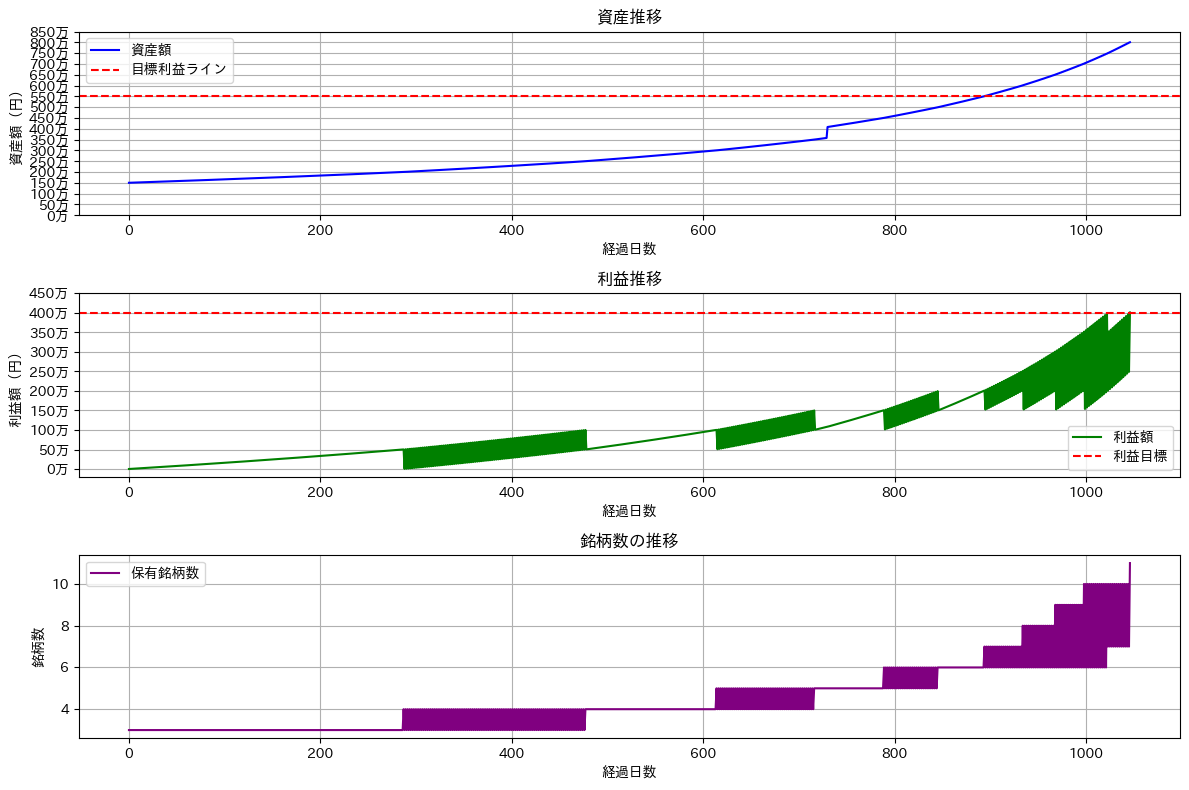

In [ ]:
# 必要なライブラリ
!pip install japanize_matplotlib
import matplotlib.pyplot as plt
import japanize_matplotlib

# フォント設定（日本語対応）
plt.rcParams['font.family'] = 'IPAexGothic'  # 環境によって 'Meiryo', 'Noto Sans CJK JP' などに変更可

# シミュレーション関数
def simulate_daily_dynamic_multistock_growth(params):
    profit_target = params["profit_target"]
    base_investment_per_stock = params["base_investment_per_stock"]
    initial_stocks = params["initial_stocks"]
    growth_rate_win = params["growth_rate_win"]
    loss_rate = params["loss_rate"]
    wins_per_stock = params["wins_per_stock"]
    losses_per_stock = params["losses_per_stock"]
    annual_top_up = params["annual_top_up"]
    top_up_day = params["top_up_day"]
    max_days = params["max_days"]
    dynamic_stock_gain_trigger = params["dynamic_stock_gain_trigger"]
    verbose = params.get("verbose", False)

    asset = base_investment_per_stock * initial_stocks
    total_profit = 0
    stock_count = initial_stocks

    asset_list = []
    day_list = []
    profit_list = []
    stock_list = []

    annual_growth = (growth_rate_win ** wins_per_stock) * (loss_rate ** losses_per_stock)
    daily_growth_rate_per_stock = annual_growth ** (1 / 365)

    for day in range(max_days + 1):
        total_growth = daily_growth_rate_per_stock ** stock_count
        asset *= total_growth

        if day == top_up_day and annual_top_up > 0:
            asset += annual_top_up

        invested = base_investment_per_stock * stock_count
        if day >= top_up_day and annual_top_up > 0:
            invested += annual_top_up
        profit = asset - invested
        total_profit = profit
        stock_count = initial_stocks + int(total_profit // dynamic_stock_gain_trigger)

        asset_list.append(asset)
        day_list.append(day)
        profit_list.append(total_profit)
        stock_list.append(stock_count)

        if verbose and day % 30 == 0:
            print(f"Day {day}: 資産 = {asset:,.0f}円 / 銘柄数 = {stock_count} / 利益 = {total_profit:,.0f}円")

        if total_profit >= profit_target:
            break

    return day_list, asset_list, profit_list, stock_list, total_profit, day

# ==== 実行パラメータ ====
params = {
    "profit_target": 4_000_000,   #目標利益額
    "base_investment_per_stock": 500_000,   #ベース投資額
    "initial_stocks": 3,   #初期投資銘柄数
    "growth_rate_win": 1.02,   #利確幅
    "loss_rate": 0.92,    #損切幅
    "wins_per_stock": 23,   #年間の購入回数（予測）
    "losses_per_stock": 4,   #年間の損切回数（予測）
    "annual_top_up": 500_000,   #追加資金
    "top_up_day": 730,   #追加資金投入日
    "max_days": 365 * 20,   #シュミレーション上限日数
    "dynamic_stock_gain_trigger": 500_000,   #利確いくら毎に銘柄を増やすか？
    "verbose": False
}

# ==== 実行 ====
days, assets, profits, stocks, final_profit, final_day = simulate_daily_dynamic_multistock_growth(params)


# ==== 設定情報の表示 ====
print("\n📌 シミュレーション設定：")
print(f"🔹 初期投資銘柄数: {params['initial_stocks']} 銘柄")
print(f"🔹 利確幅: +{round((params['growth_rate_win'] - 1) * 100, 1)}% × {params['wins_per_stock']} 回")
print(f"🔹 損切幅: -{round((1 - params['loss_rate']) * 100, 1)}% × {params['losses_per_stock']} 回")
print(f"🔹 年間損切り回数: {params['losses_per_stock']} 回")
print(f"🔹 追加資金額: {params['annual_top_up']:,.0f}円")
print(f"🔹 追加資金: {'あり' if params['annual_top_up'] > 0 else 'なし'}（{params['top_up_day']}日目）")

# ==== 結果表示 ====
years = final_day // 365
remainder_days = final_day % 365
print(f"\n✅ 達成日数: {final_day}日（約{years}年と{remainder_days}日）")
print(f"💰 最終資産: {assets[-1]:,.0f}円")
print(f"📈 利益合計: {final_profit:,.0f}円")
print(f"📊 最終保有銘柄数: {stocks[-1]}")


# ==== グラフ表示 ====
import numpy as np  # 忘れずに追加！

plt.figure(figsize=(12, 8))

# === 資産グラフ ===
plt.subplot(3, 1, 1)
plt.plot(days, assets, label="資産額", color="blue")
plt.axhline(y=assets[0] + params["profit_target"], color='r', linestyle='--', label="目標利益ライン")
plt.title("資産推移")
plt.xlabel("経過日数")
plt.ylabel("資産額（円）")
plt.grid(True)
plt.legend()

# 目盛り（50万円刻み＋ラベルを日本語で）
max_asset = max(assets)
yticks_asset = np.arange(0, max_asset + 500_000, 500_000)
ytick_labels_asset = [f"{int(y // 10000)}万" for y in yticks_asset]
plt.yticks(yticks_asset, ytick_labels_asset)

# === 利益グラフ ===
plt.subplot(3, 1, 2)
plt.plot(days, profits, label="利益額", color="green")
plt.axhline(y=params["profit_target"], color='red', linestyle='--', label="利益目標")
plt.title("利益推移")
plt.xlabel("経過日数")
plt.ylabel("利益額（円）")
plt.grid(True)
plt.legend()

# 目盛り（利益も同様に日本語表記）
max_profit = max(profits)
yticks_profit = np.arange(0, max_profit + 500_000, 500_000)
ytick_labels_profit = [f"{int(y // 10000)}万" for y in yticks_profit]
plt.yticks(yticks_profit, ytick_labels_profit)

# === 銘柄数グラフ（そのままでOK） ===
plt.subplot(3, 1, 3)
plt.plot(days, stocks, label="保有銘柄数", color="purple")
plt.title("銘柄数の推移")
plt.xlabel("経過日数")
plt.ylabel("銘柄数")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


